# Code 2: Exploratory Analysis of Bayesian Models

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(5201)

## Understanding Your Assumptions

### Figure 2.2

In [3]:
half_length = 3.66  # meters
penalty_point = 11  # meters
def Phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * pm.math.erf(x / (2.0)**0.5)


ppss = []
sigmas_deg = [5, 20, 60]
sigmas_rad = np.deg2rad(sigmas_deg)
for sigma in sigmas_rad:
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", sigma)
        α = pm.Normal("α", 0, σ)
        p_goal = pm.Deterministic("p_goal", 2 * Phi(pm.math.arctan(half_length / penalty_point) / σ) - 1)
        pps = pm.sample_prior_predictive(250)
        ppss.append(pps)

Sampling: [α, σ]
Sampling: [α, σ]
Sampling: [α, σ]


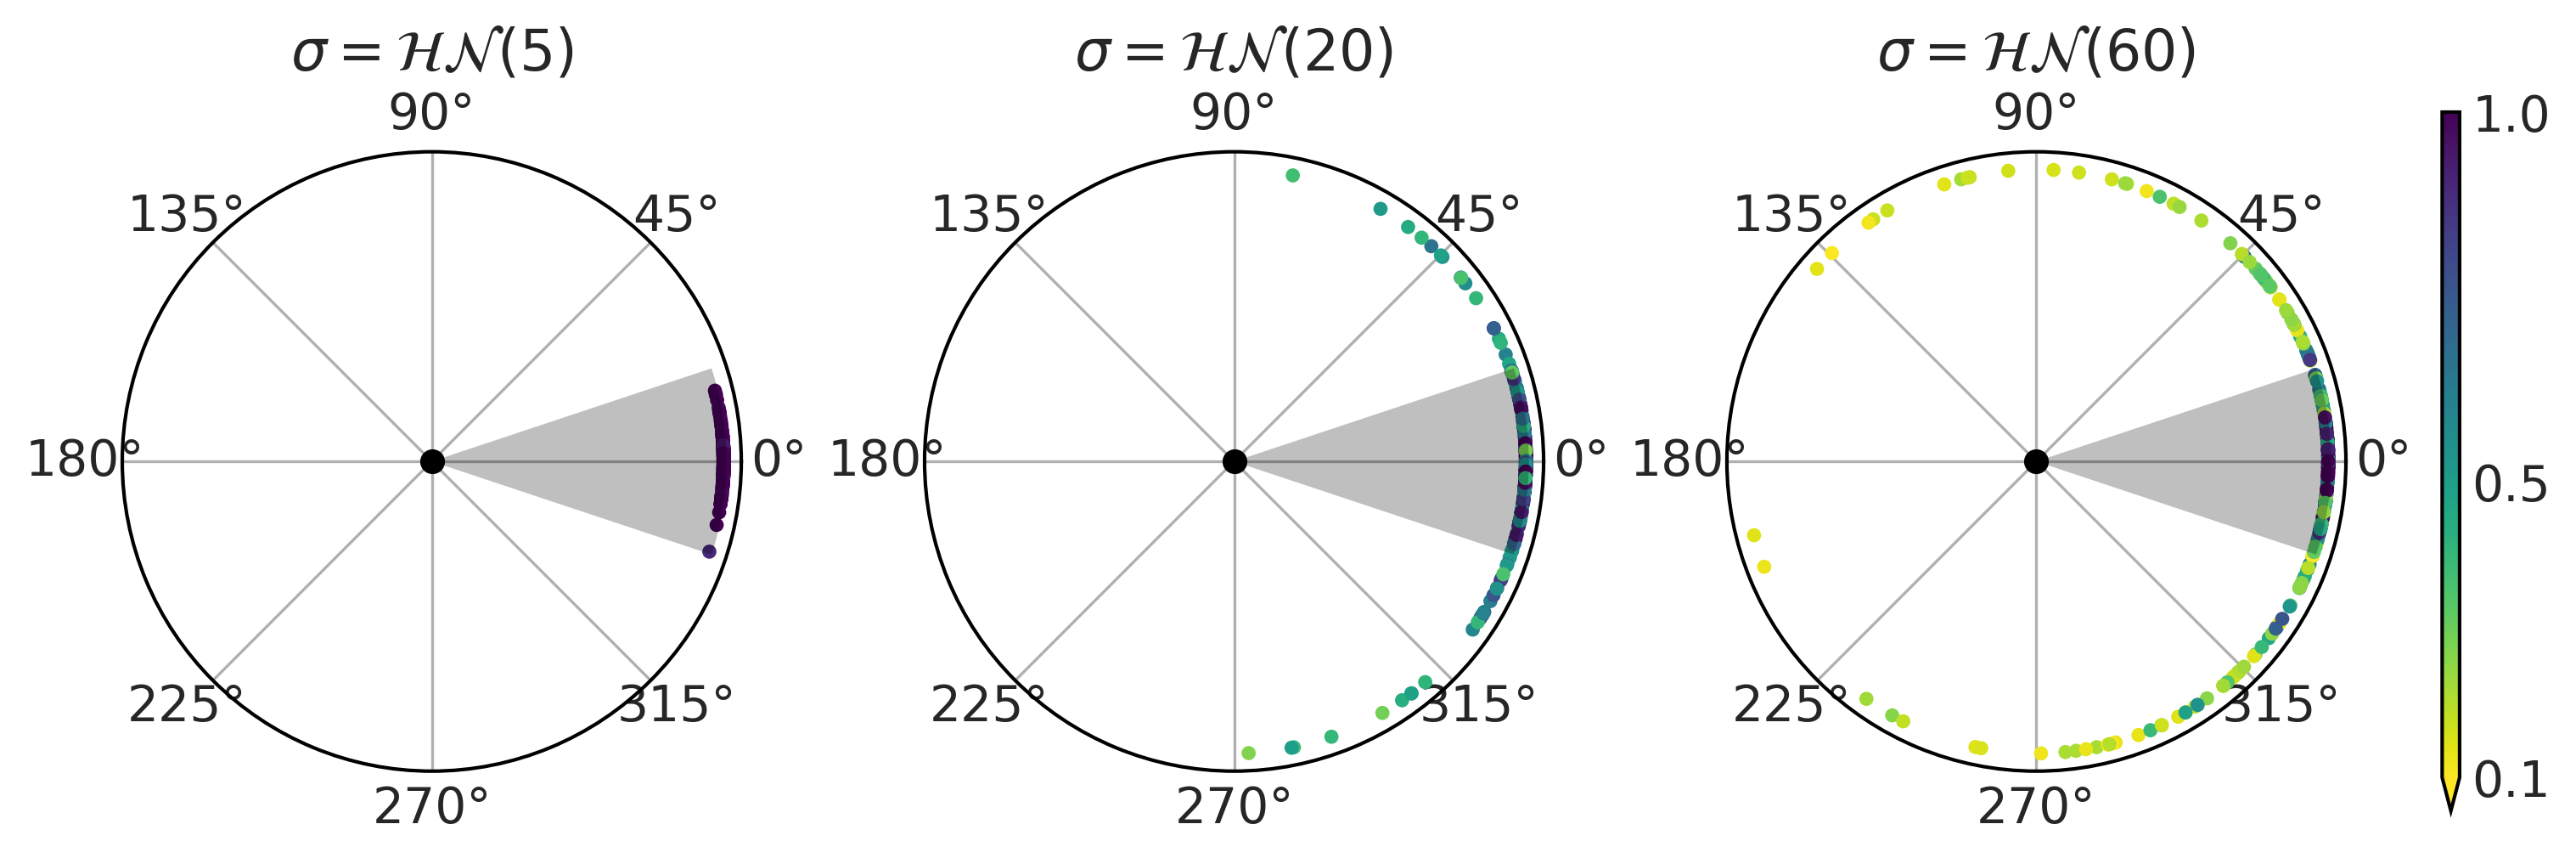

In [4]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection="polar"), figsize=(10, 4))

max_angle = np.arctan(half_length/penalty_point)

for sigma, pps, ax in zip(sigmas_deg, ppss, axes):
    cutoff = pps.prior["p_goal"] > 0.1
    values = pps.prior["α"].where(cutoff)
    cax = ax.scatter(values, np.ones_like(values), c=pps.prior["p_goal"].where(cutoff),
               marker=".", cmap="viridis_r", vmin=0.1)
    ax.fill_between(np.linspace(-max_angle, max_angle, 100), 0, 1.01, alpha=0.25)
    ax.set_yticks([])
    ax.set_title(f"$\sigma = \mathcal{{HN}}({sigma})$")
    ax.plot(0,0, 'o')
fig.colorbar(cax, extend="min", ticks=[1, 0.5, 0.1], shrink=0.7, aspect=40)

plt.savefig("img/chp02/prior_predictive_distributions_00.png", bbox_inches="tight")

### Figure 2.3

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


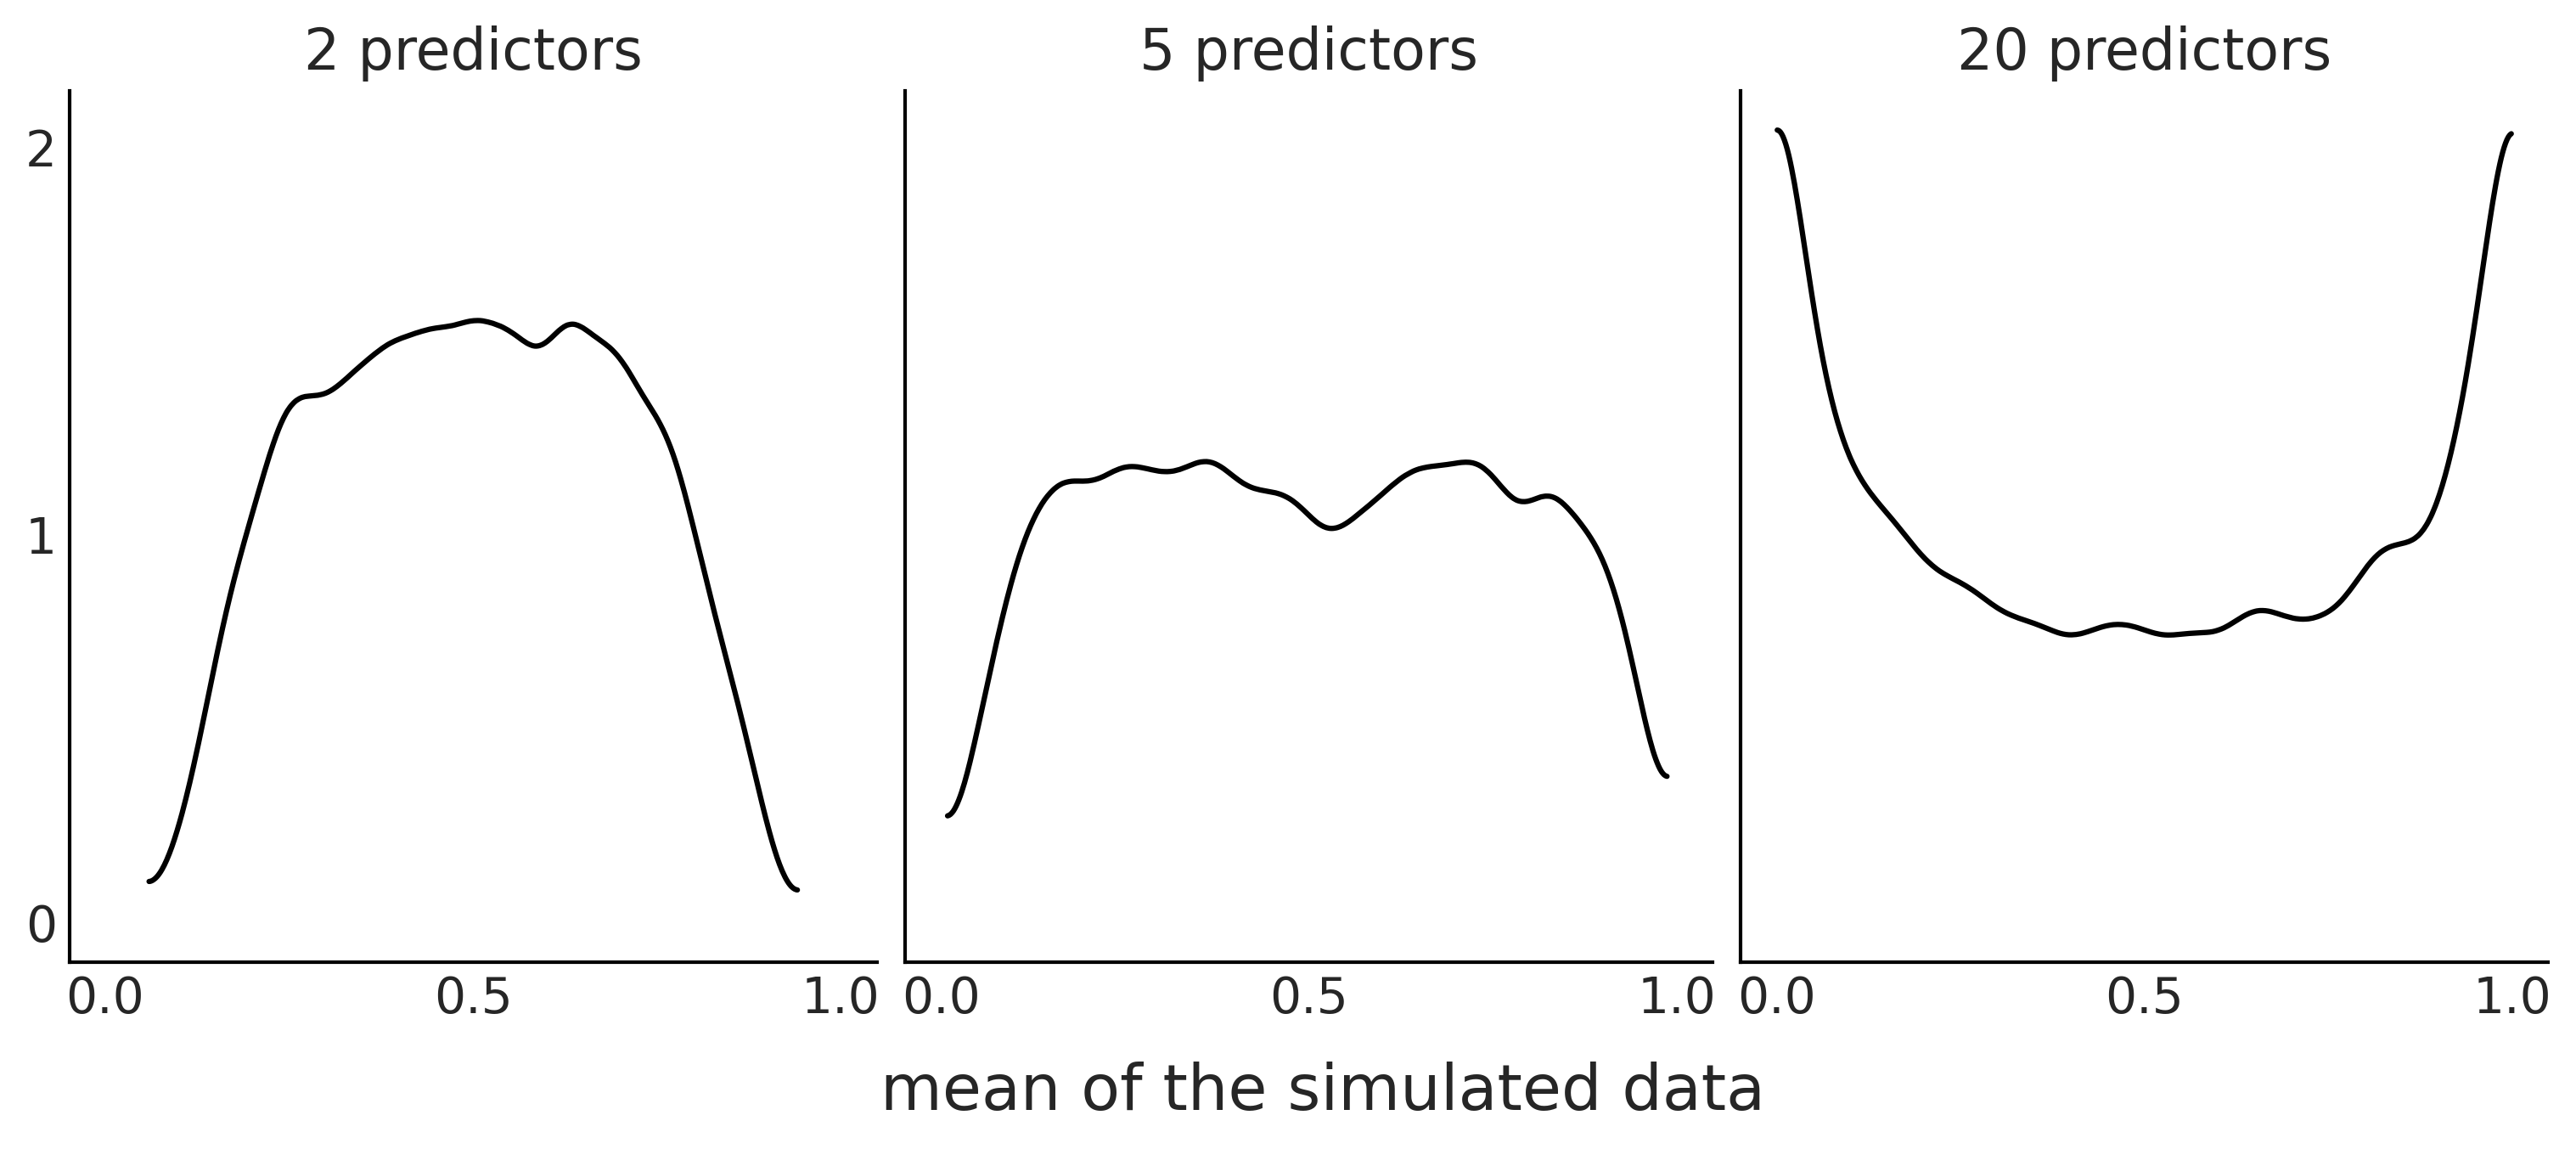

In [5]:
from scipy.special import expit
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True,  sharey=True)
axes = np.ravel(axes)

for dim, ax in zip([2, 5, 20], axes):
    β = np.random.normal(0, 1, size=(10000, dim))
    X = np.random.binomial(n=1, p=0.75, size=(dim, 500))
    az.plot_kde(expit(β @ X).mean(1), ax=ax)
    ax.set_title(f"{dim} predictors")
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])

fig.text(0.34, -0.075, size=18, s="mean of the simulated data")
plt.savefig("img/chp02/prior_predictive_distributions_01.png", bbox_inches="tight")

## Understanding Your Predictions

### Figure 2.4

In [6]:
Y = stats.bernoulli(0.7).rvs(100)
with pm.Model() as model:
    θ = pm.Beta("θ", 1, 1)
    y_obs = pm.Binomial("y_obs",n=1, p=θ, observed=Y)
    idata_b = pm.sample(1000)
    idata_b.extend(pm.sample_posterior_predictive(idata_b))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Sampling: [y_obs]


In [7]:
pred_dist = az.extract(idata_b, group="posterior_predictive", num_samples=1000)["y_obs"].values
pred_dist.sum(0).shape

(1000,)

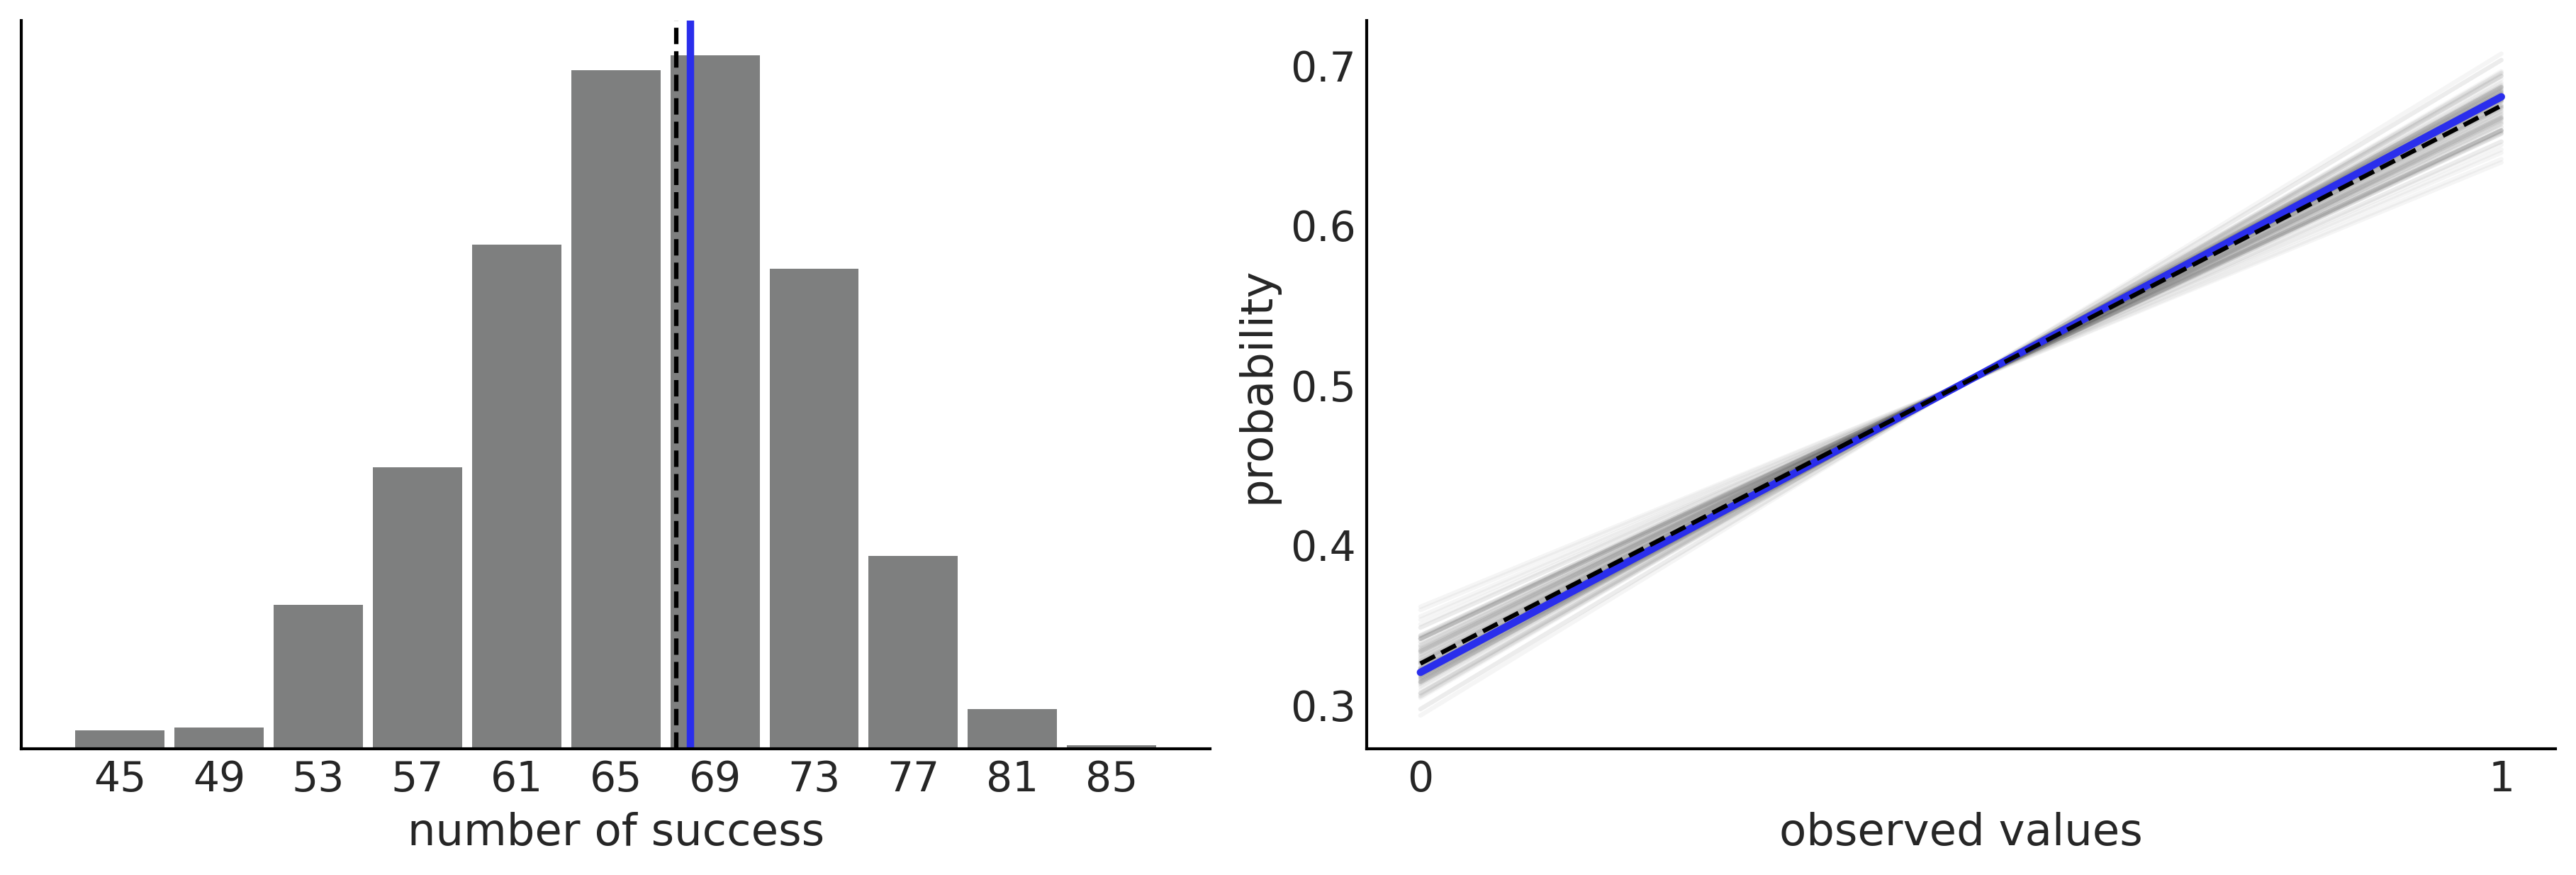

In [8]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

az.plot_dist(pred_dist.sum(0),
             hist_kwargs={"color":"C2"}, ax=ax[0])
ax[0].axvline(Y.sum(), color="C4", lw=2.5)
ax[0].axvline(pred_dist.sum(0).mean(), color="k", ls="--")
ax[0].set_yticks([])
ax[0].set_xlabel("number of success")

pps_ = pred_dist.mean(1)
ax[1].plot((np.zeros_like(pps_), np.ones_like(pps_)), (1-pps_, pps_), 'C1', alpha=0.05)

ax[1].plot((0, 1), (1-Y.mean(), Y.mean()), 'C4', lw=2.5)
ax[1].plot((0, 1), (1-pps_.mean(), pps_.mean()), 'k--')
ax[1].set_xticks((0,1))
ax[1].set_xlabel("observed values")
ax[1].set_ylabel("probability")
plt.savefig("img/chp02/posterior_predictive_check.png")

### Figure 2.5

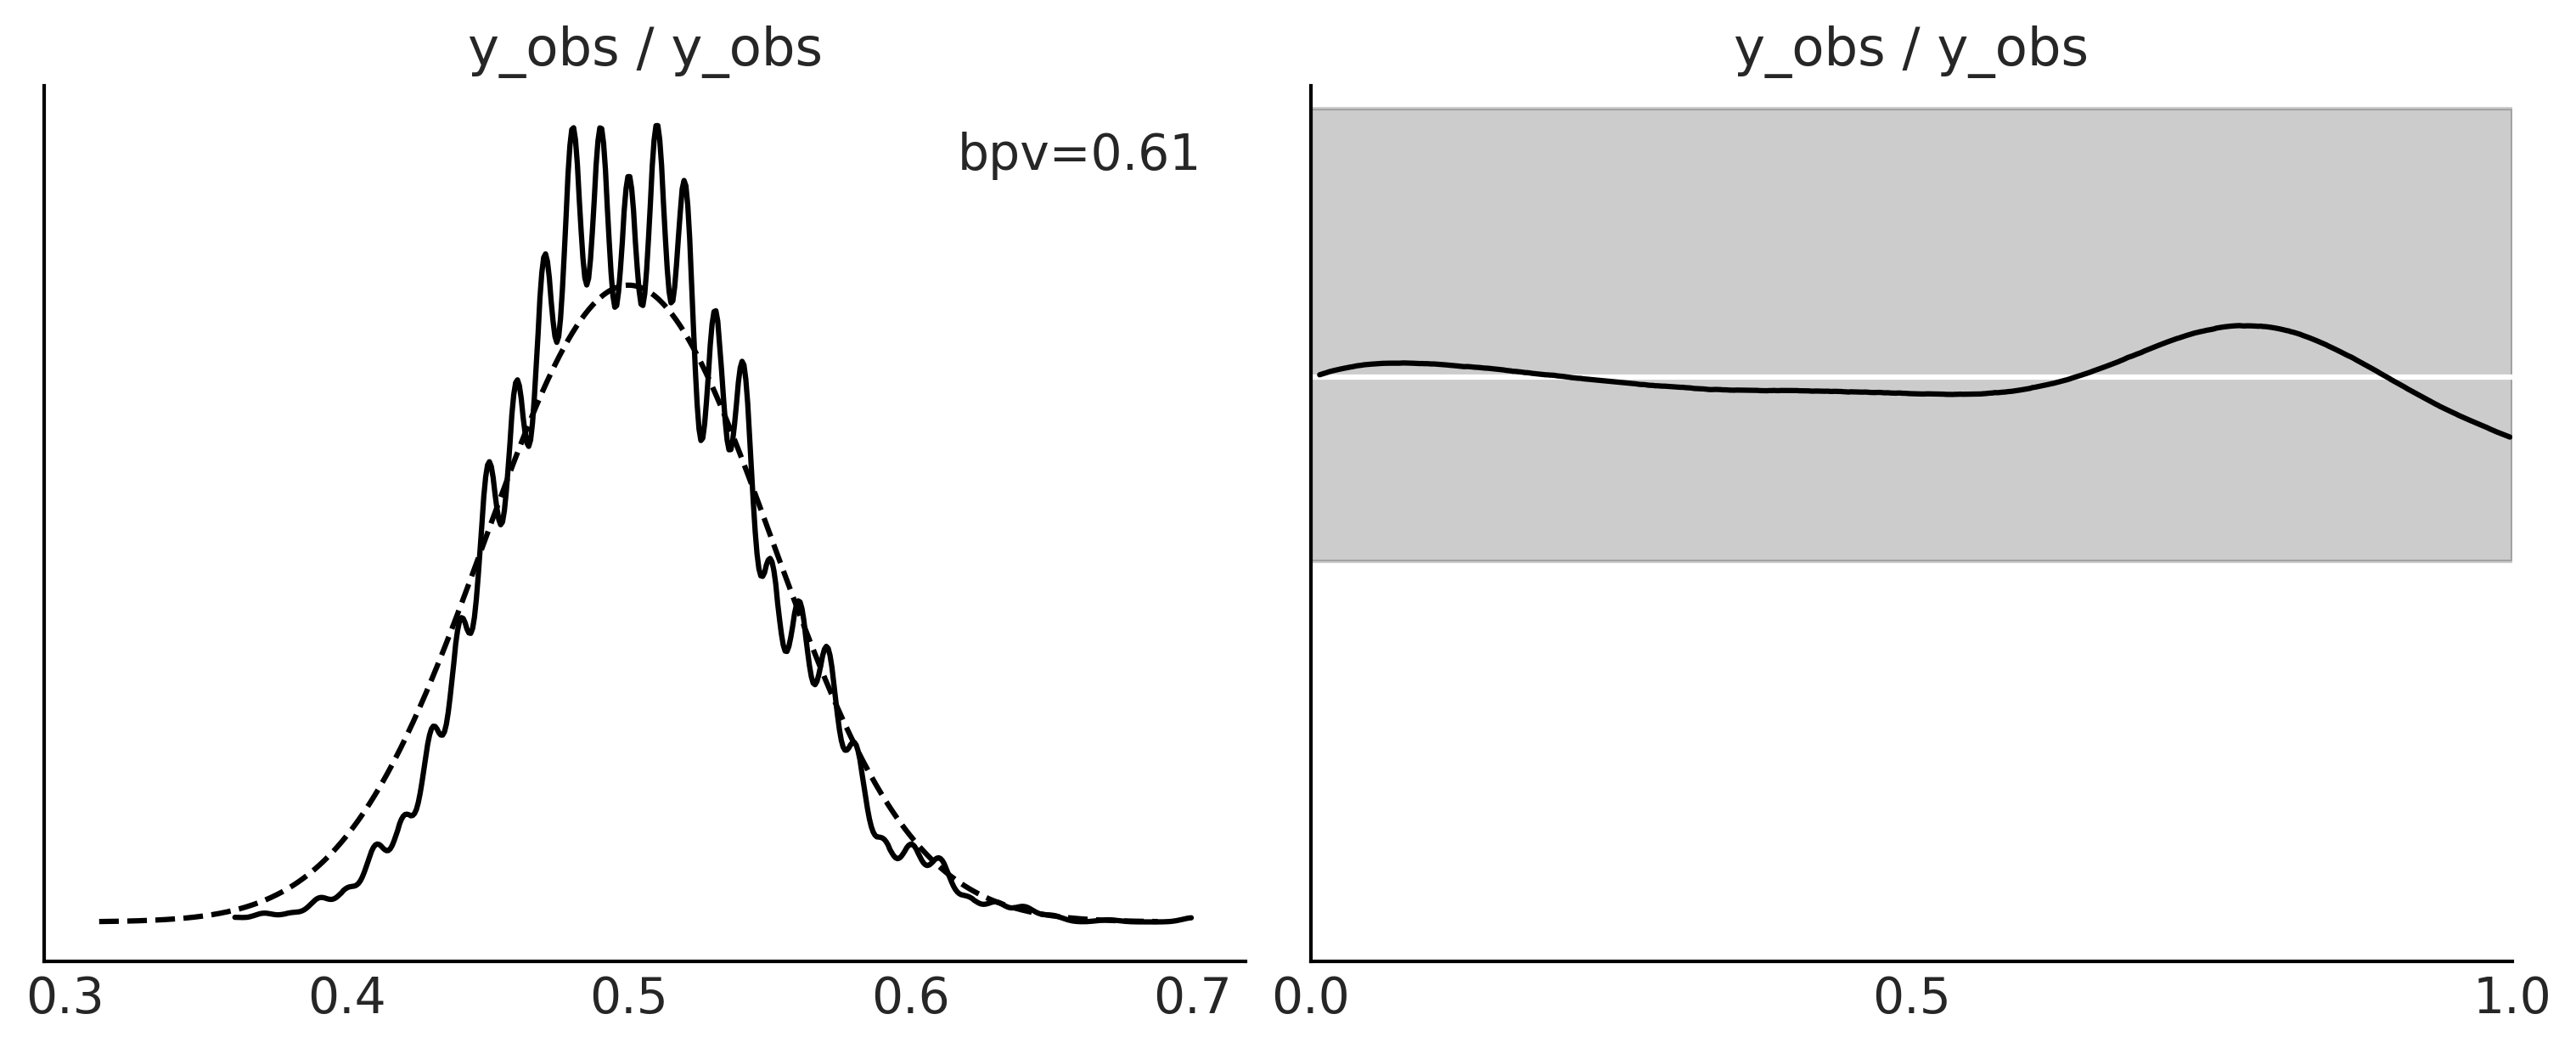

In [9]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata_b, kind="p_value", ax=ax[0])
ax[0].legend([f"bpv={(Y.mean() > pred_dist.mean(1)).mean():.2f}"], handlelength=0)
az.plot_bpv(idata_b, kind="u_value", ax=ax[1])
ax[1].set_yticks([])
ax[1].set_xticks([0., 0.5, 1.])
plt.savefig("img/chp02/posterior_predictive_check_pu_values.png")

### Figure 2.6

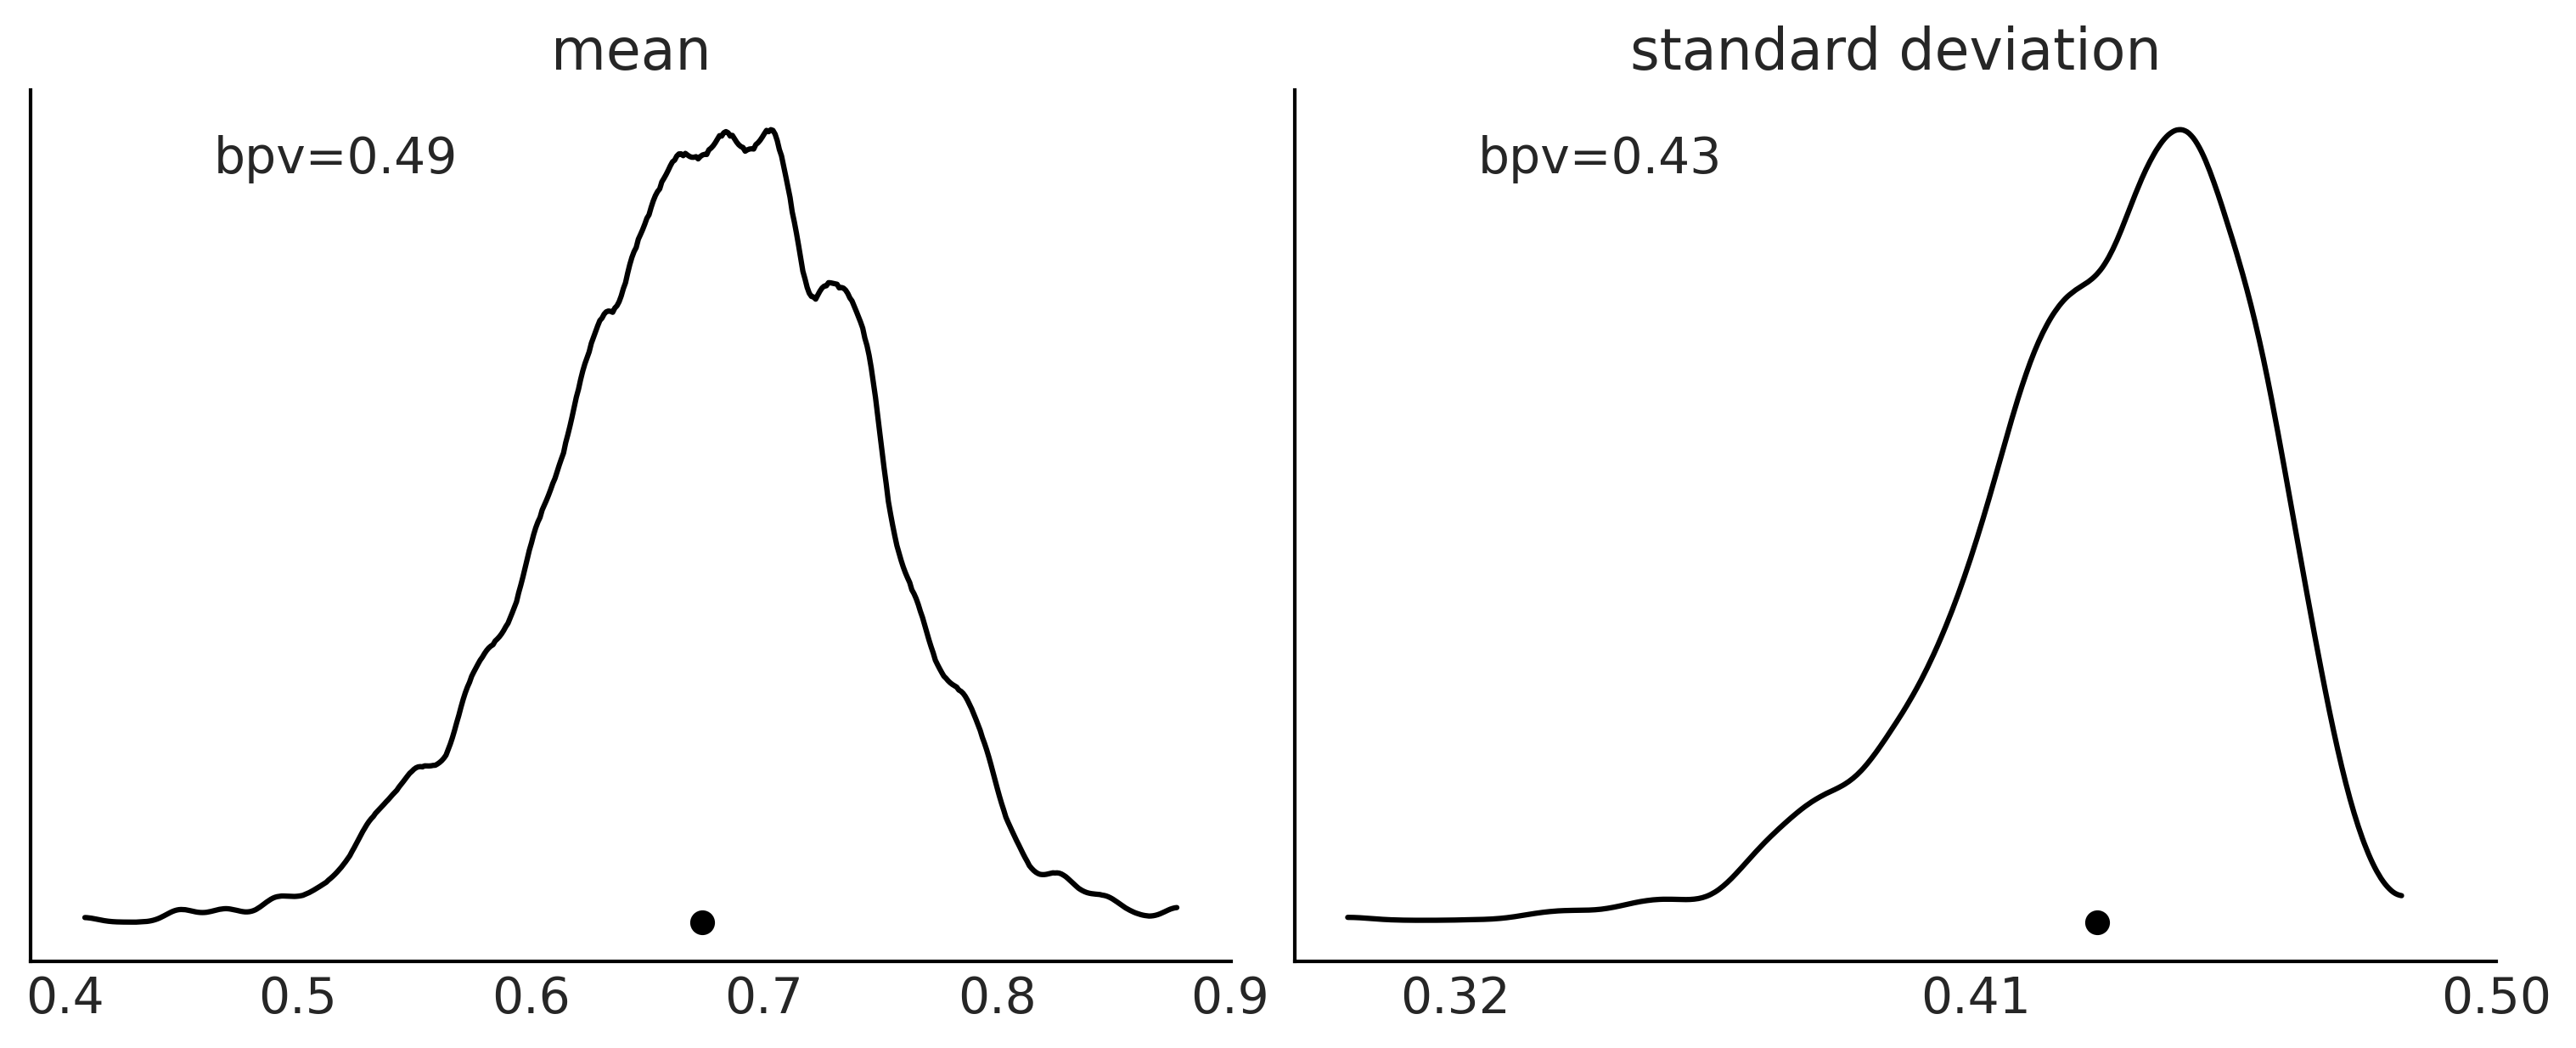

In [10]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata_b, kind="t_stat", t_stat="mean", ax=ax[0])
ax[0].set_title("mean")
az.plot_bpv(idata_b, kind="t_stat", t_stat="std", ax=ax[1])
ax[1].set_title("standard deviation")
ax[1].set_xticks([0.32, 0.41, 0.5])
plt.savefig("img/chp02/posterior_predictive_check_tstat.png")

### Figure 2.7

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/plots/ppcplot.py:241: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


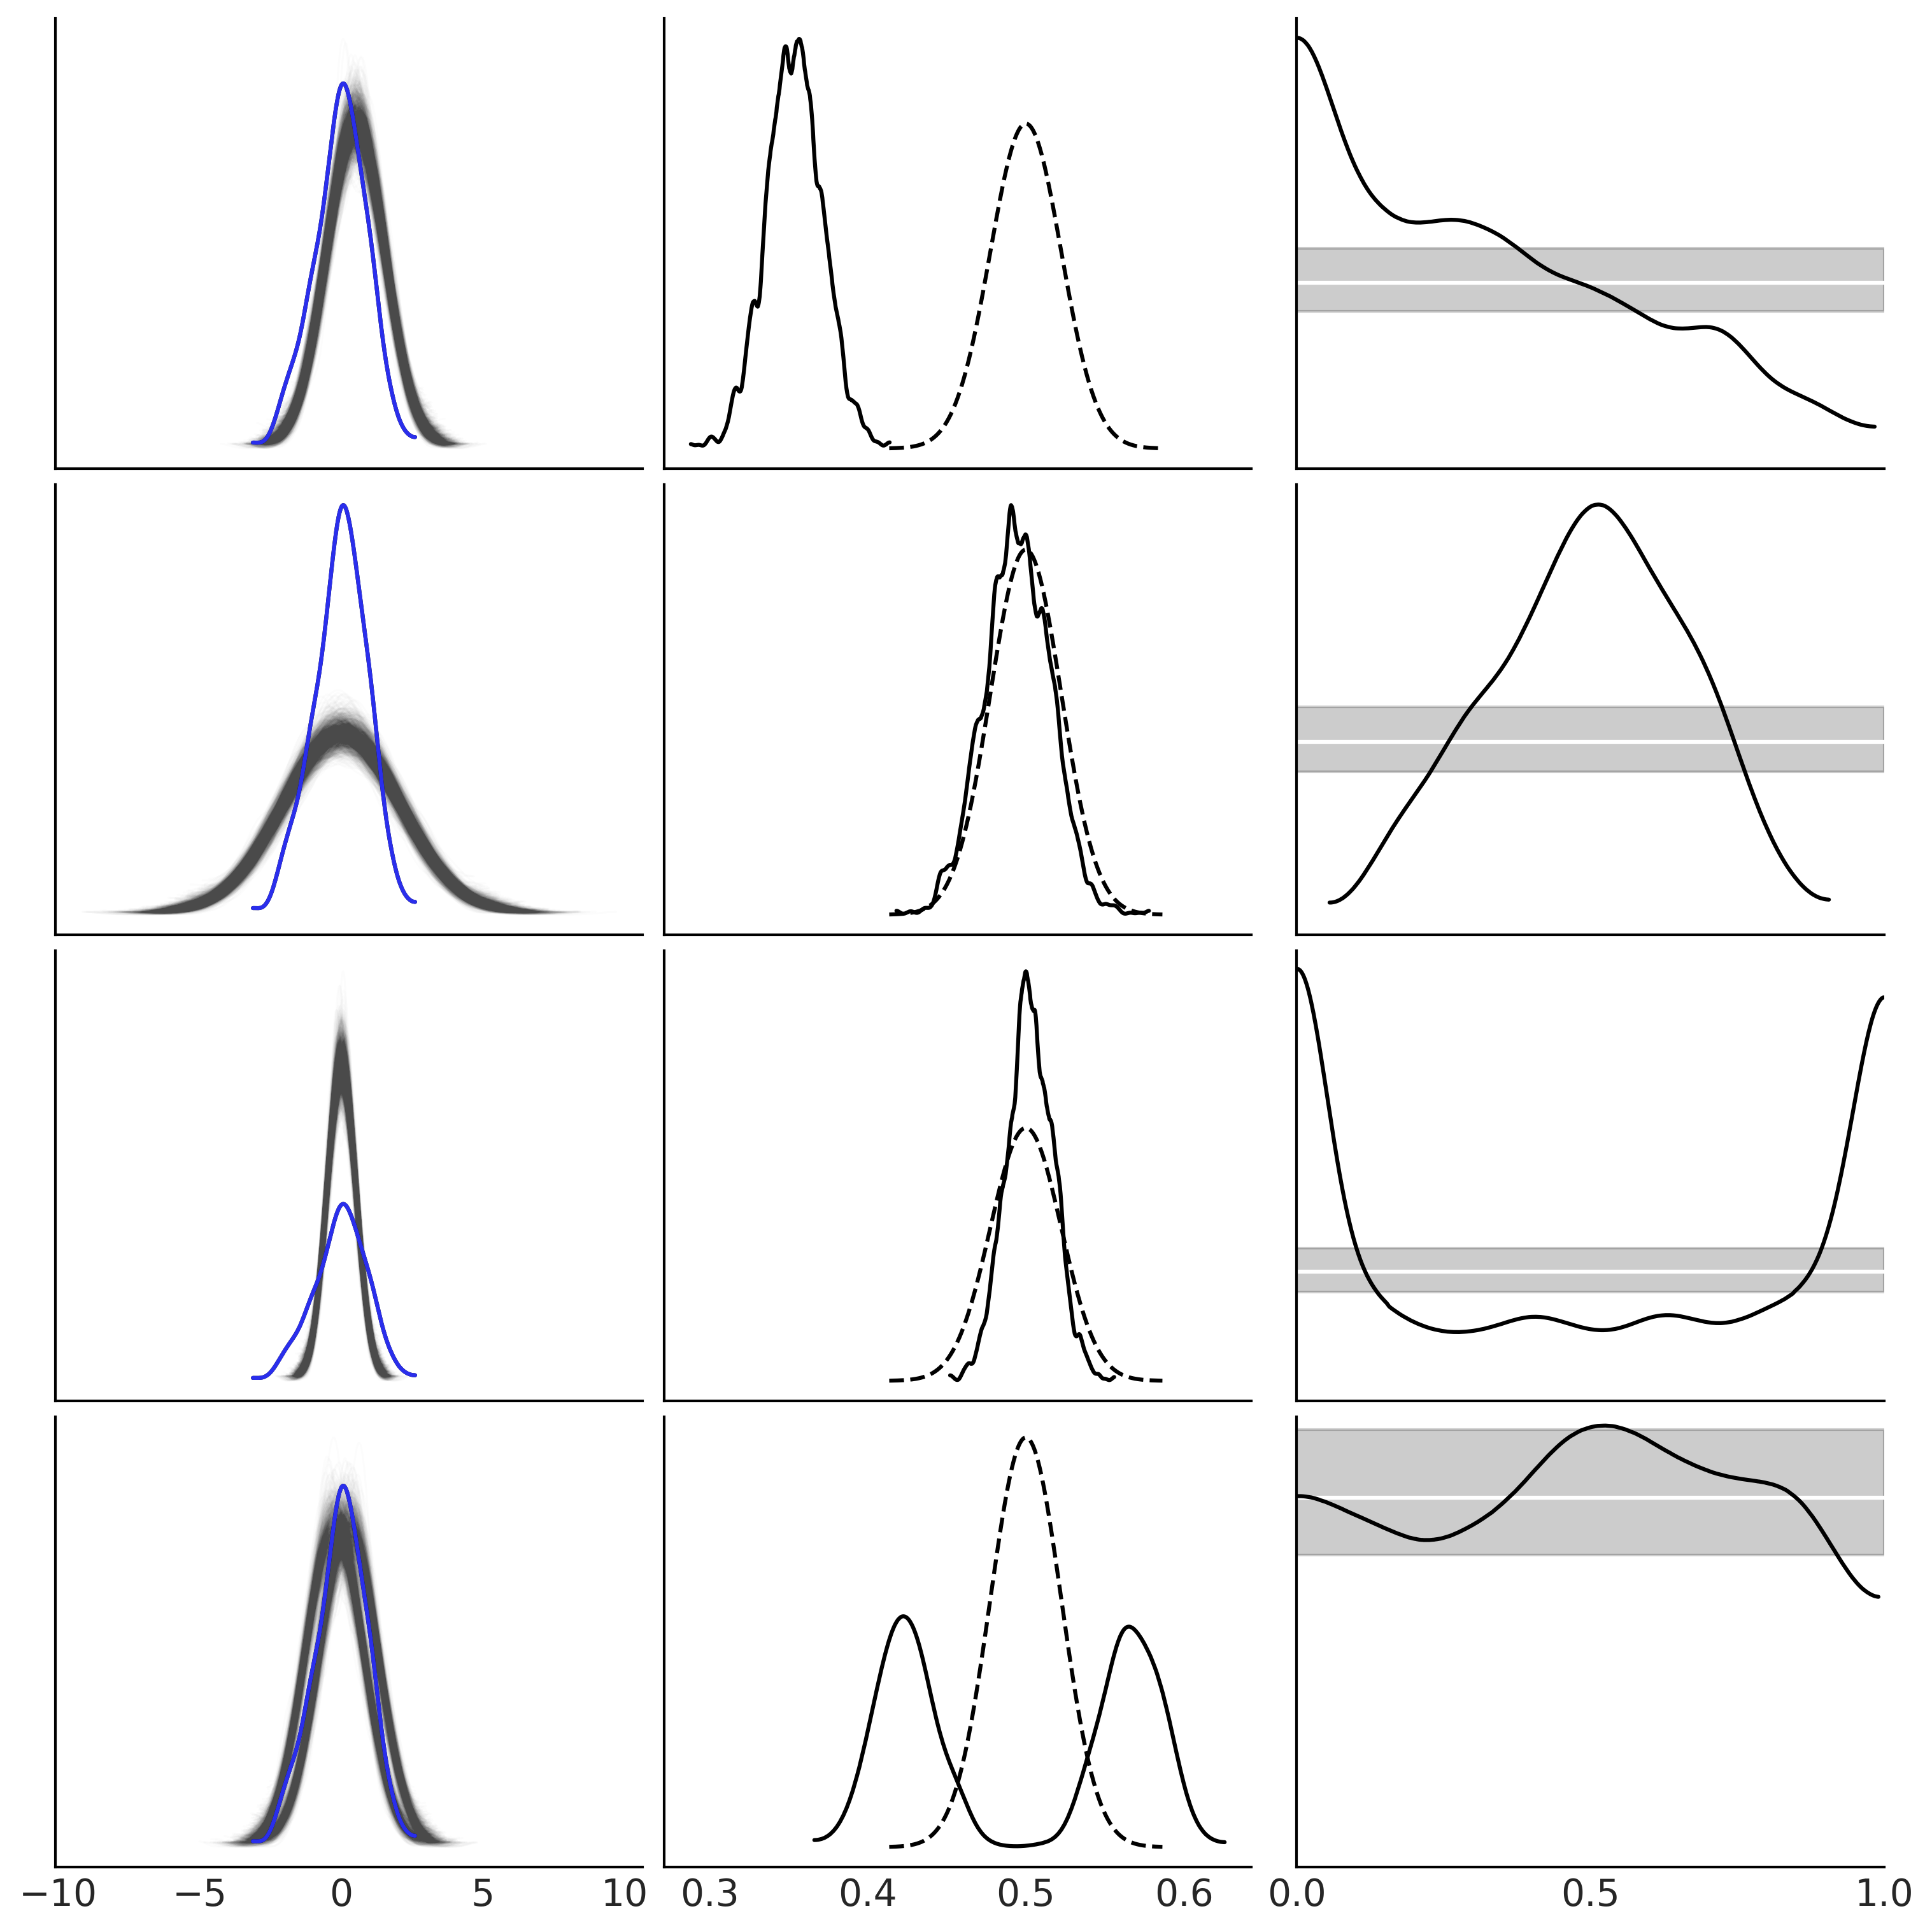

In [11]:
n_obs = 500
samples = 2000
y_obs = np.random.normal(0, 1, size=n_obs)

idata1 = az.from_dict(posterior_predictive={"y":np.random.normal(0.5, 1, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata2 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 2, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata3 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 0.5, size=(1, samples,n_obs))},
                      observed_data={"y":y_obs})

idata4 = az.from_dict(posterior_predictive={"y":np.concatenate(
                                                [np.random.normal(-0.25, 1, size=(1, samples//2, n_obs)),
                                                 np.random.normal(0.25, 1, size=(1, samples//2, n_obs))]
                                                                )},
                      observed_data={"y":y_obs})

idatas = [idata1,
          idata2,
          idata3,
          idata4,
]

_, axes = plt.subplots(len(idatas), 3, figsize=(10, 10), sharex="col")

for idata, ax in zip(idatas, axes):
    az.plot_ppc(idata, ax=ax[0], color="C1", alpha=0.01, mean=False, legend=False)
    az.plot_kde(idata.observed_data["y"].values, ax=ax[0], plot_kwargs={"color":"C4", "zorder":3})
    ax[0].set_xlabel("")
    az.plot_bpv(idata, kind="p_value", ax=ax[1])
    az.plot_bpv(idata, kind="u_value", ax=ax[2])
    ax[2].set_yticks([])
    ax[2].set_xticks([0., 0.5, 1.])
    for ax_ in ax:
        ax_.set_title("")

plt.savefig("img/chp02/posterior_predictive_many_examples.png")

## Diagnosing Numerical Inference

### Code 2.1

In [12]:
np.random.seed(5201)

In [13]:
good_chains = stats.beta.rvs(2, 5,size=(2, 2000))
bad_chains0 = np.random.normal(np.sort(good_chains, axis=None), 0.05,
                               size=4000).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i%2:,i:i+100] = np.random.beta(i, 950, size=100)

chains = {"good_chains":good_chains,
          "bad_chains0":bad_chains0,
          "bad_chains1":bad_chains1}

### Code 2.2

In [14]:
az.ess(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 4.389e+03
    bad_chains0  float64 2.436
    bad_chains1  float64 111.1

### Code 2.3 and Figure 2.8

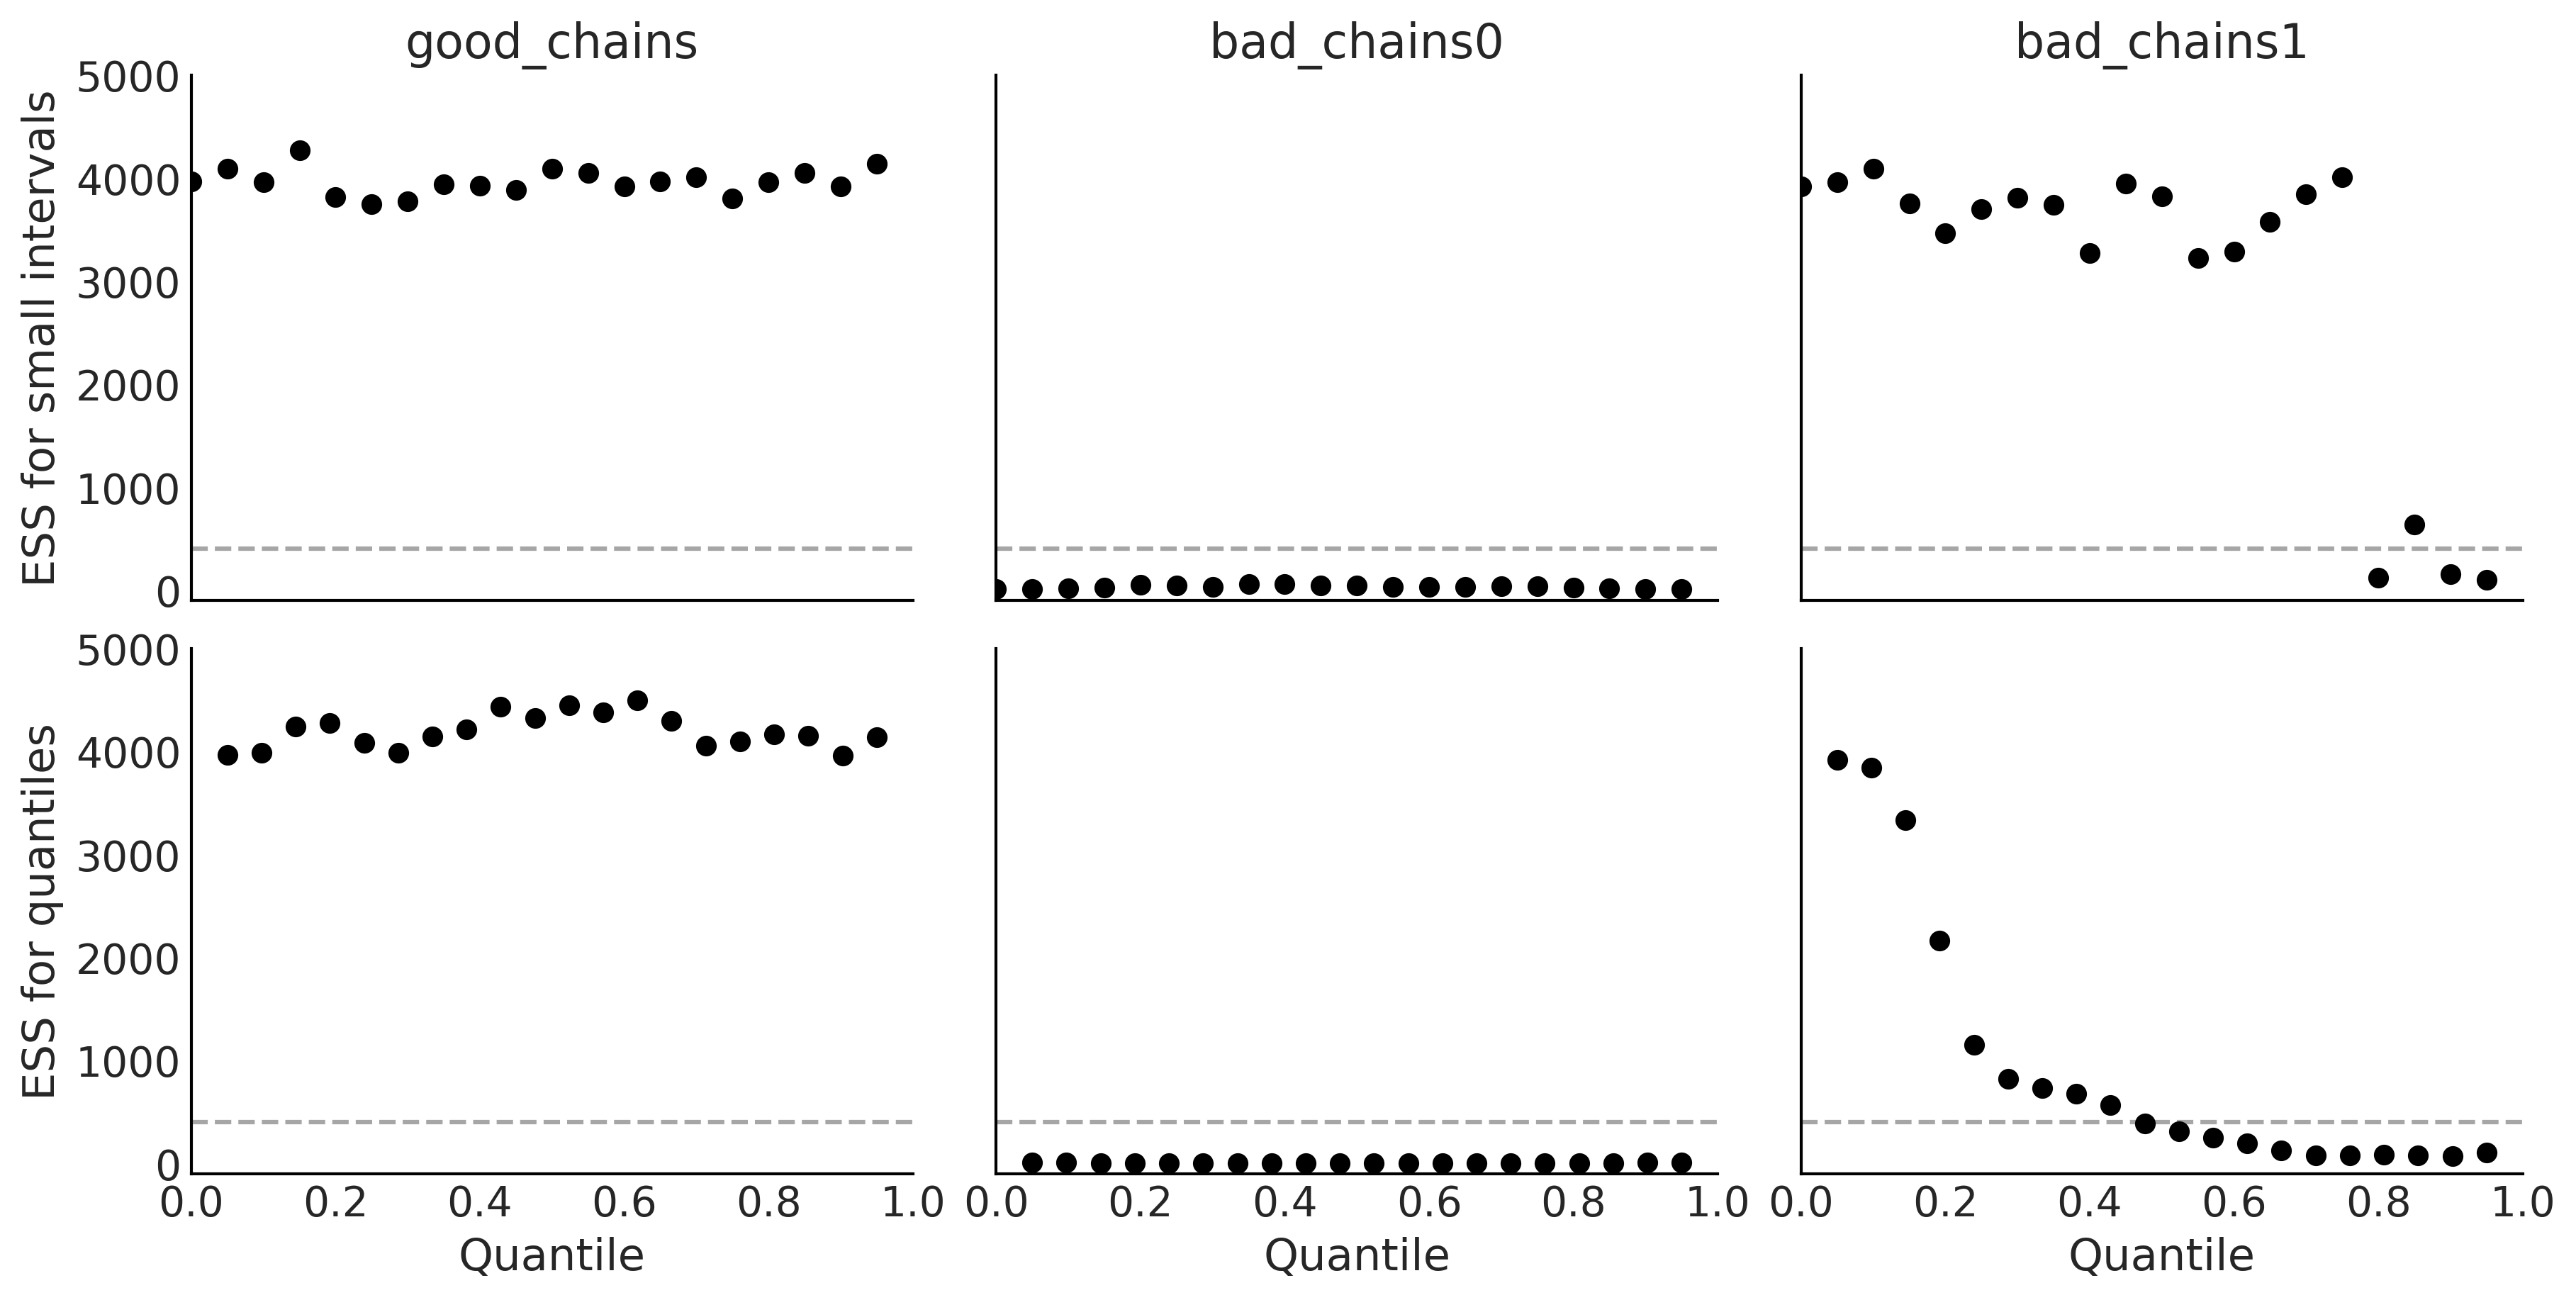

In [15]:
_, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0])
az.plot_ess(chains, kind="quantile", ax=axes[1])

for ax_ in axes[0]:
    ax_.set_xlabel("")
for ax_ in axes[1]:
    ax_.set_title("")

for ax_ in axes[:,1:].ravel():
    ax_.set_ylabel("")
plt.ylim(-100, 5000)
plt.savefig("img/chp02/plot_ess.png")

### Code 2.4

In [16]:
az.rhat(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 1.0
    bad_chains0  float64 2.408
    bad_chains1  float64 1.033

### Code 2.5

In [17]:
az.mcse(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 0.002381
    bad_chains0  float64 0.1077
    bad_chains1  float64 0.01781

### Code 2.6 and Figure 2.9

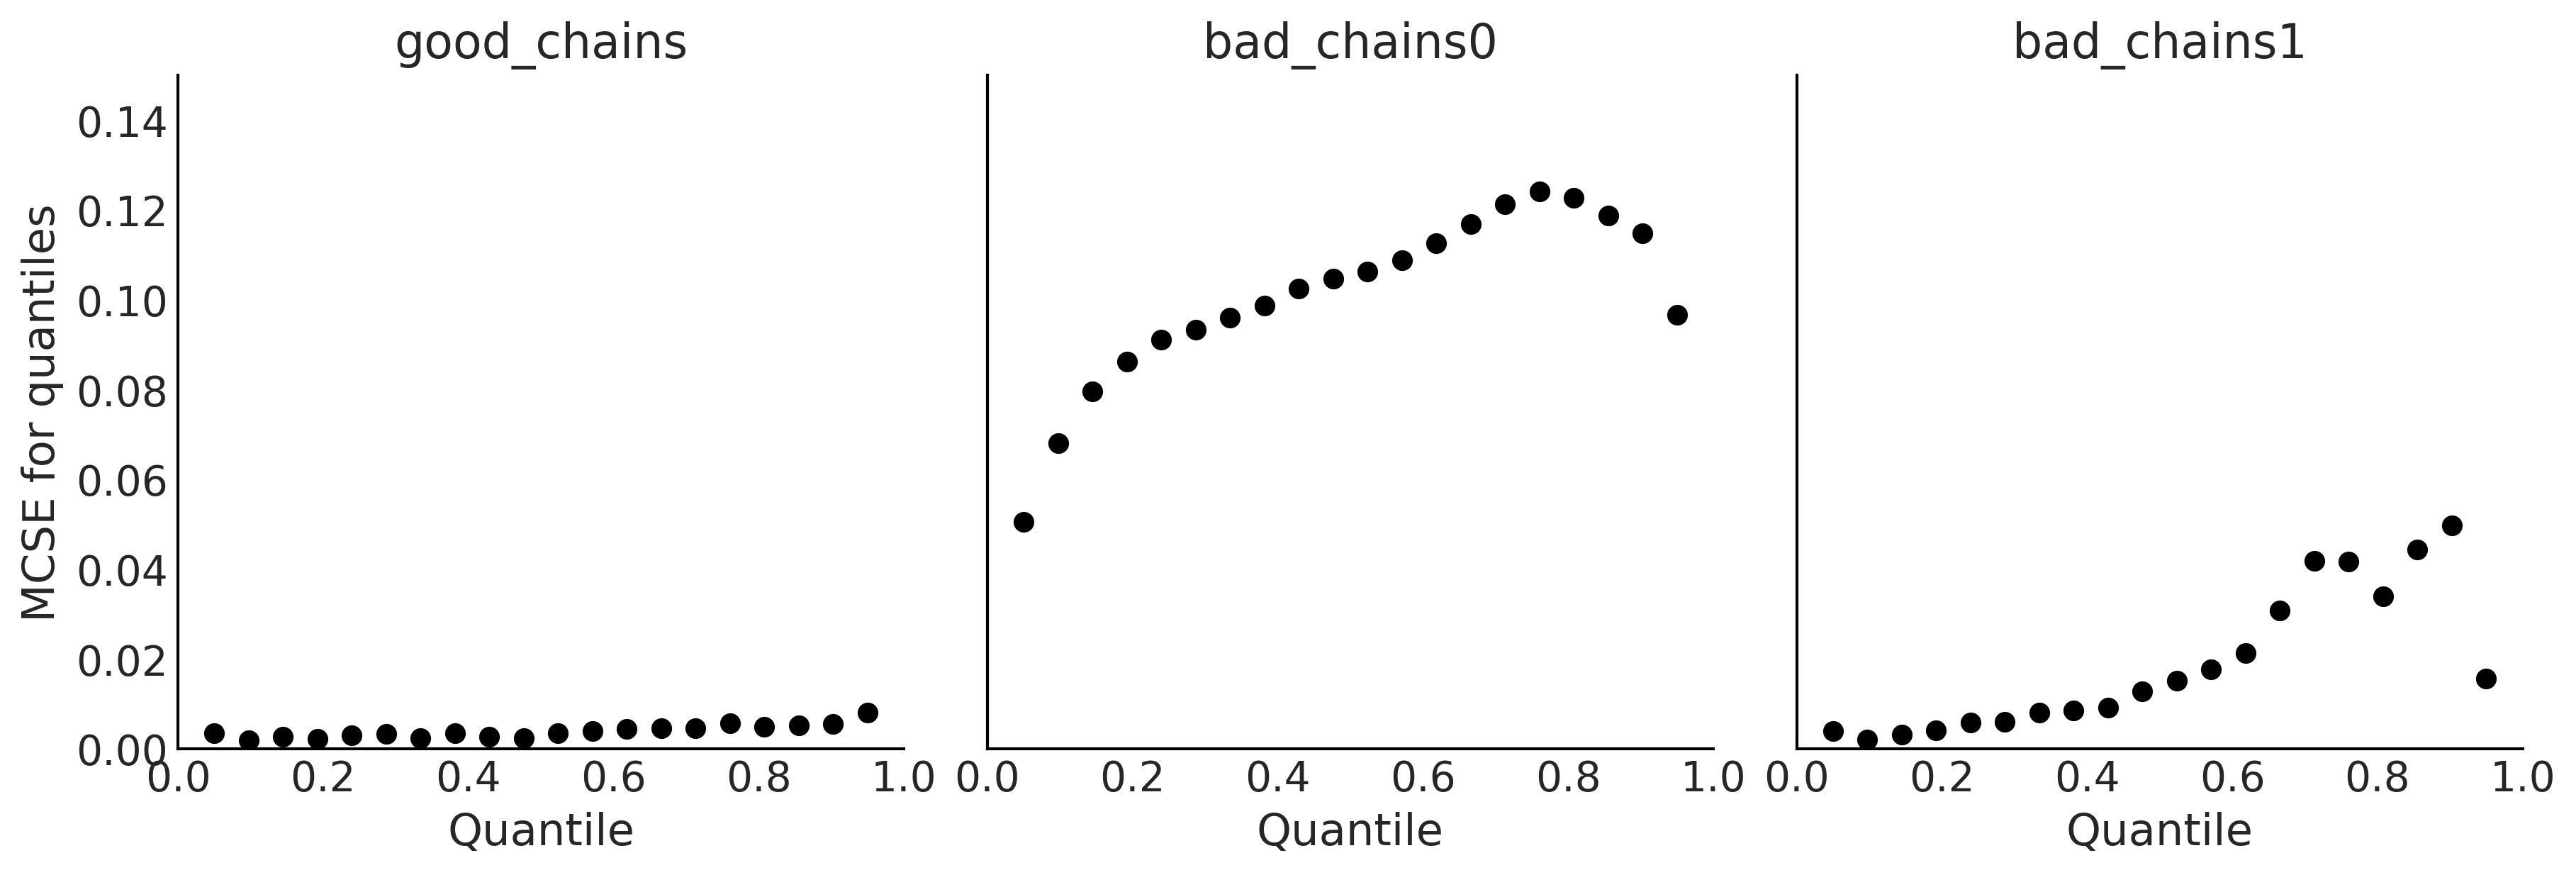

In [18]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
az.plot_mcse(chains, ax=axes)
for ax_ in axes[1:]:
    ax_.set_ylabel("")
    ax_.set_ylim(0, 0.15)

plt.savefig("img/chp02/plot_mcse.png")

### Code 2.7

In [19]:
az.summary(chains, kind="diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
good_chains      0.002    0.002    4389.0    3966.0   1.00
bad_chains0      0.108    0.088       2.0      11.0   2.41
bad_chains1      0.018    0.013     111.0     105.0   1.03

### Code 2.8 and Figure 2.10

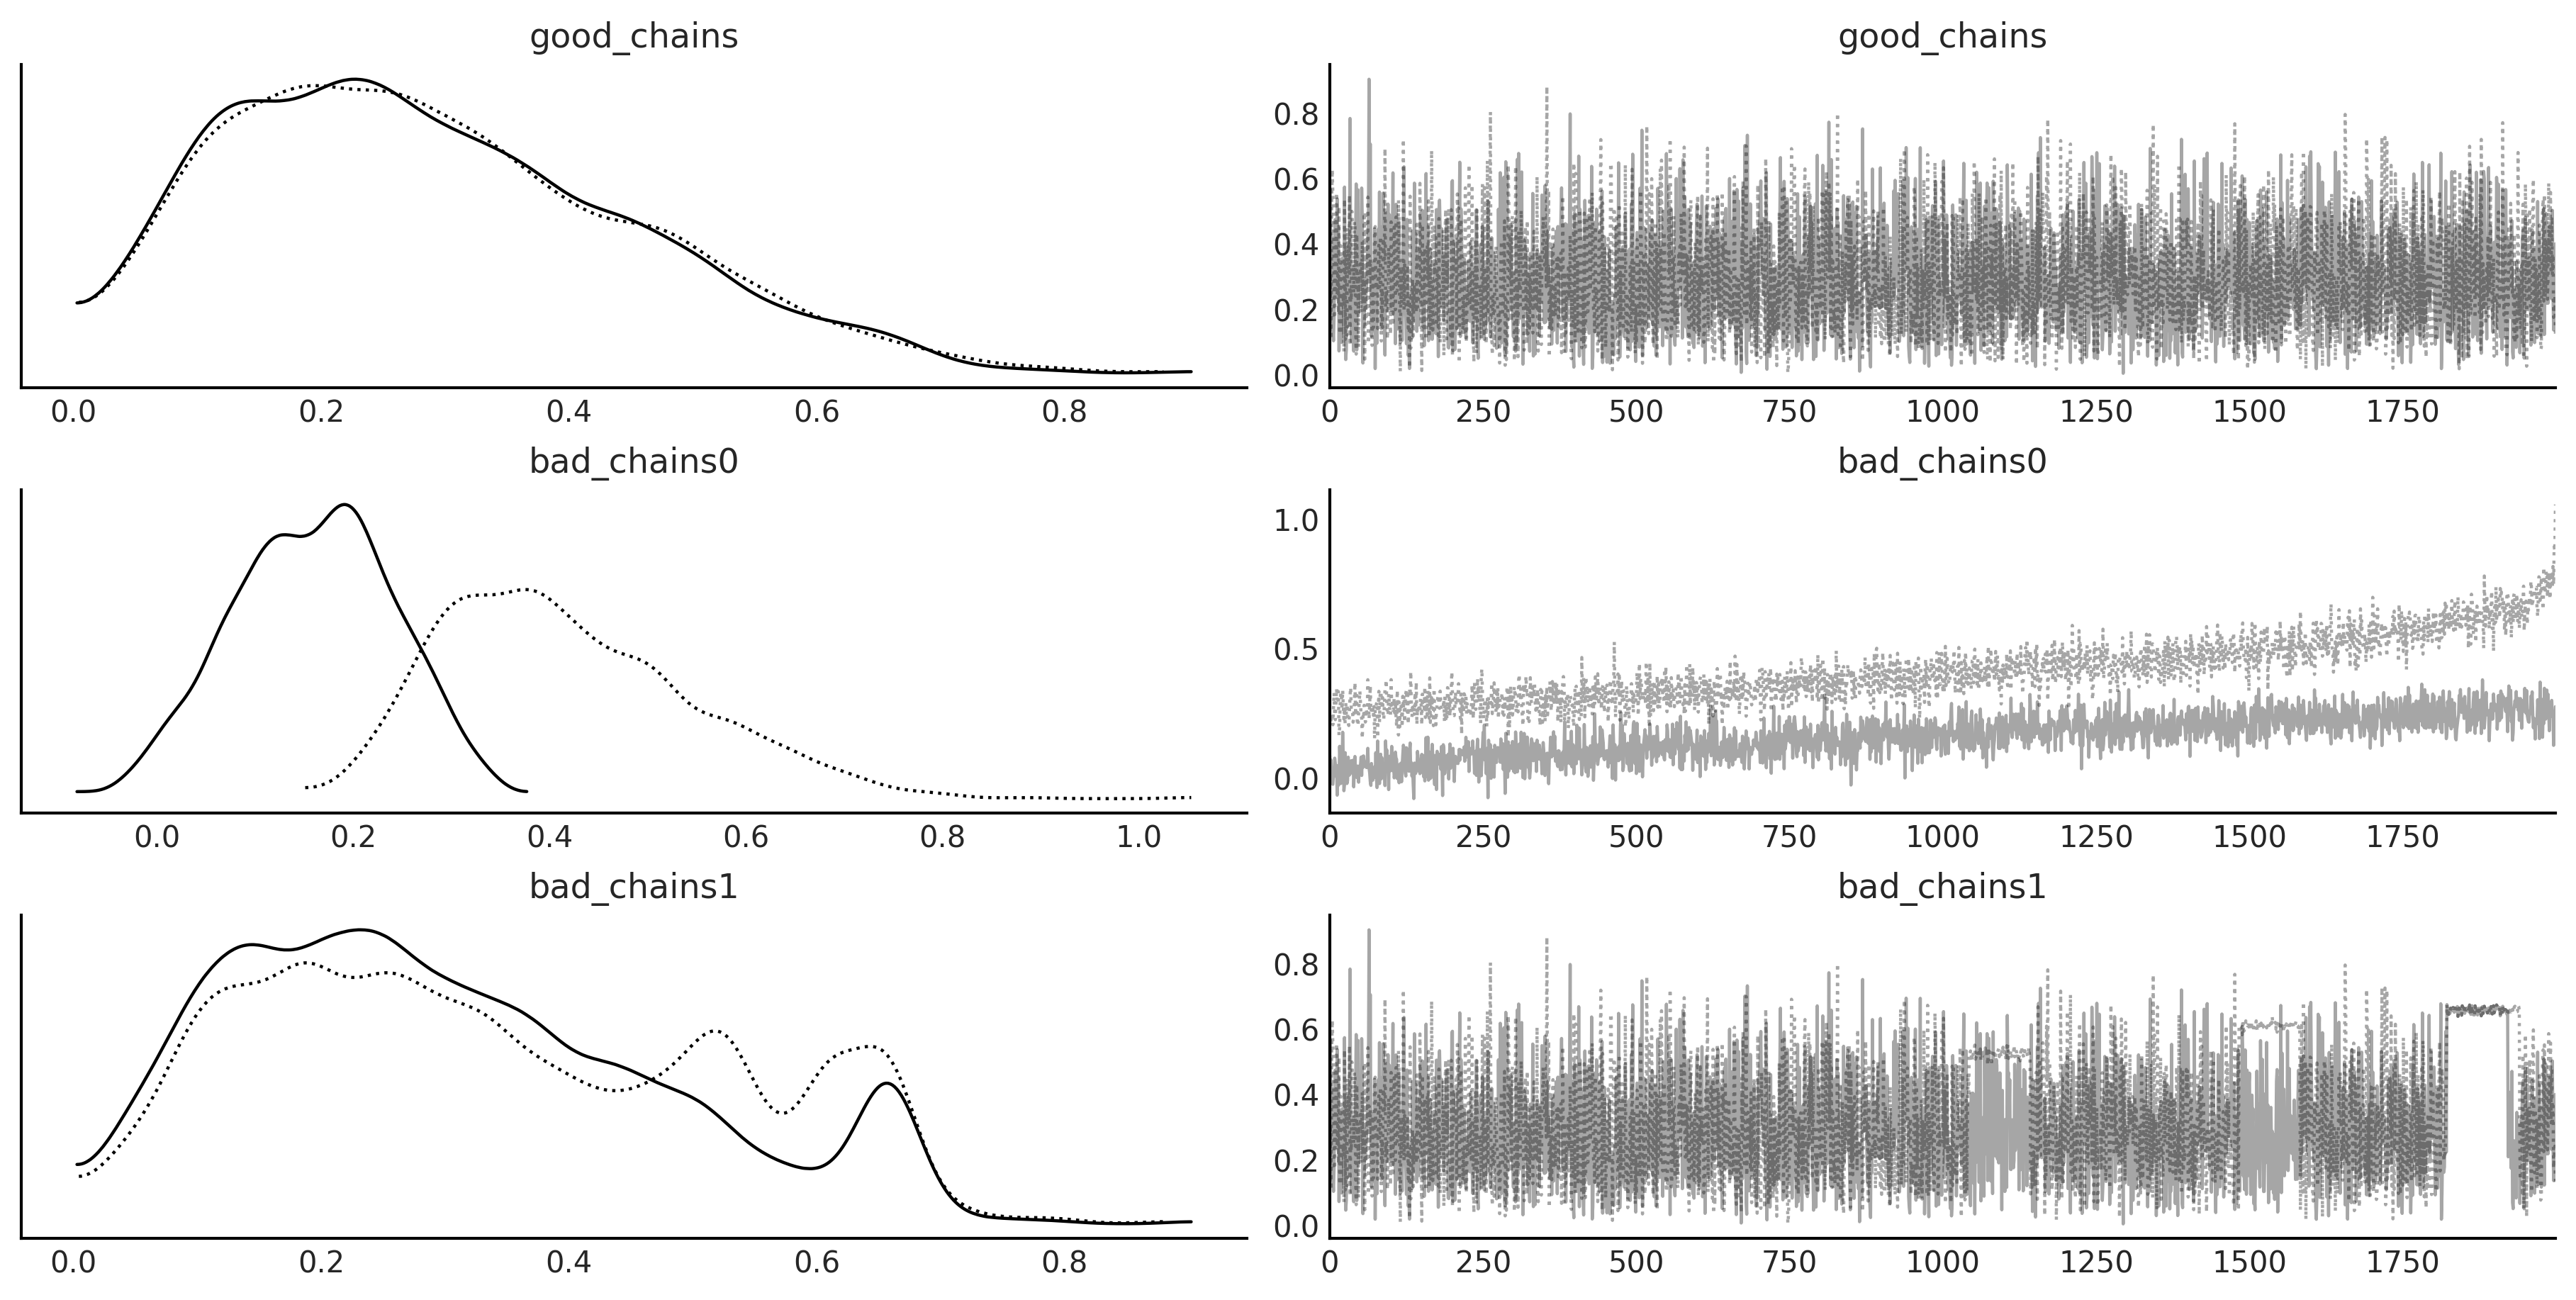

In [20]:
az.plot_trace(chains)
plt.savefig("img/chp02/trace_plots.png")

### Code 2.9 and Figure 2.11

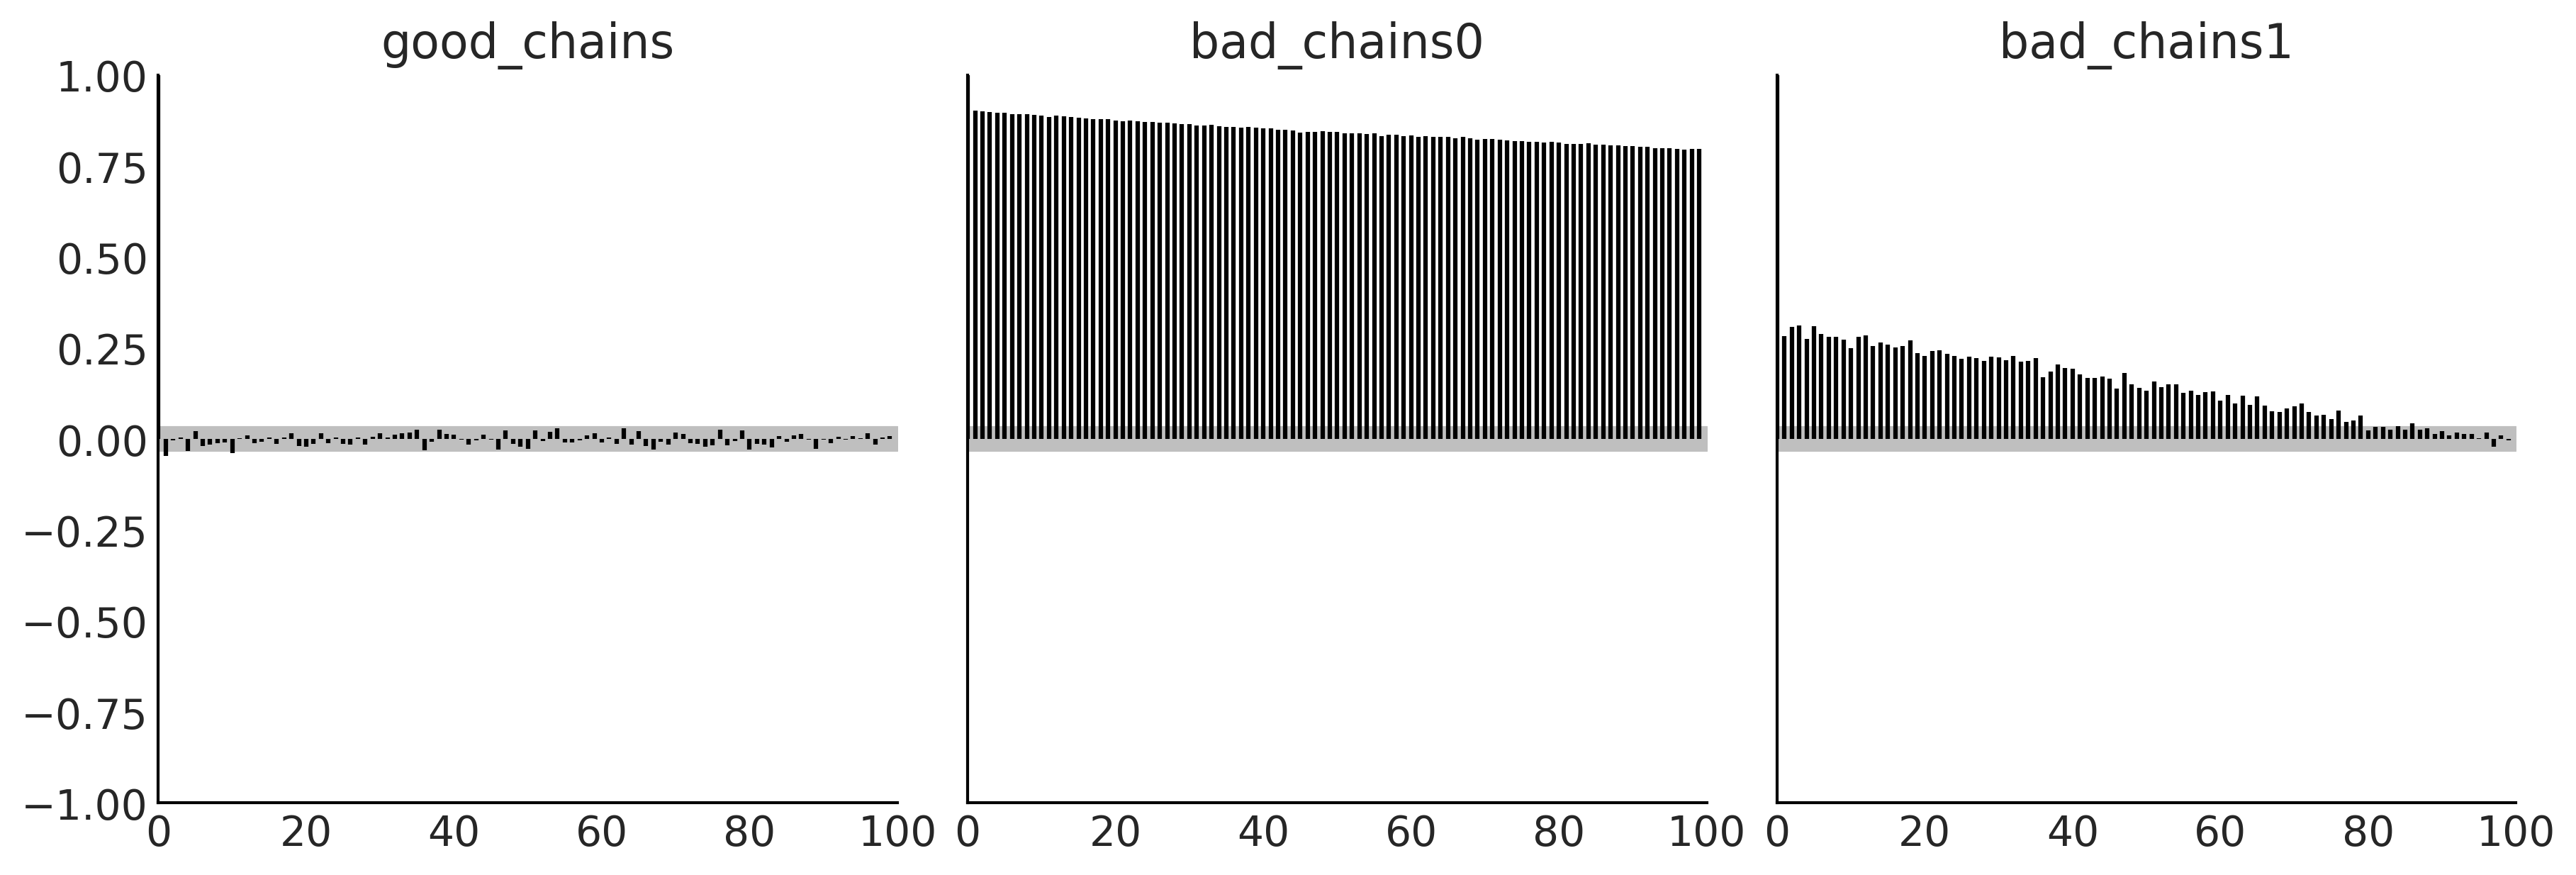

In [21]:
az.plot_autocorr(chains, combined=True, figsize=(12, 4))
plt.savefig('img/chp02/autocorrelation_plot.png')

### Code 2.10 and Figure 2.12

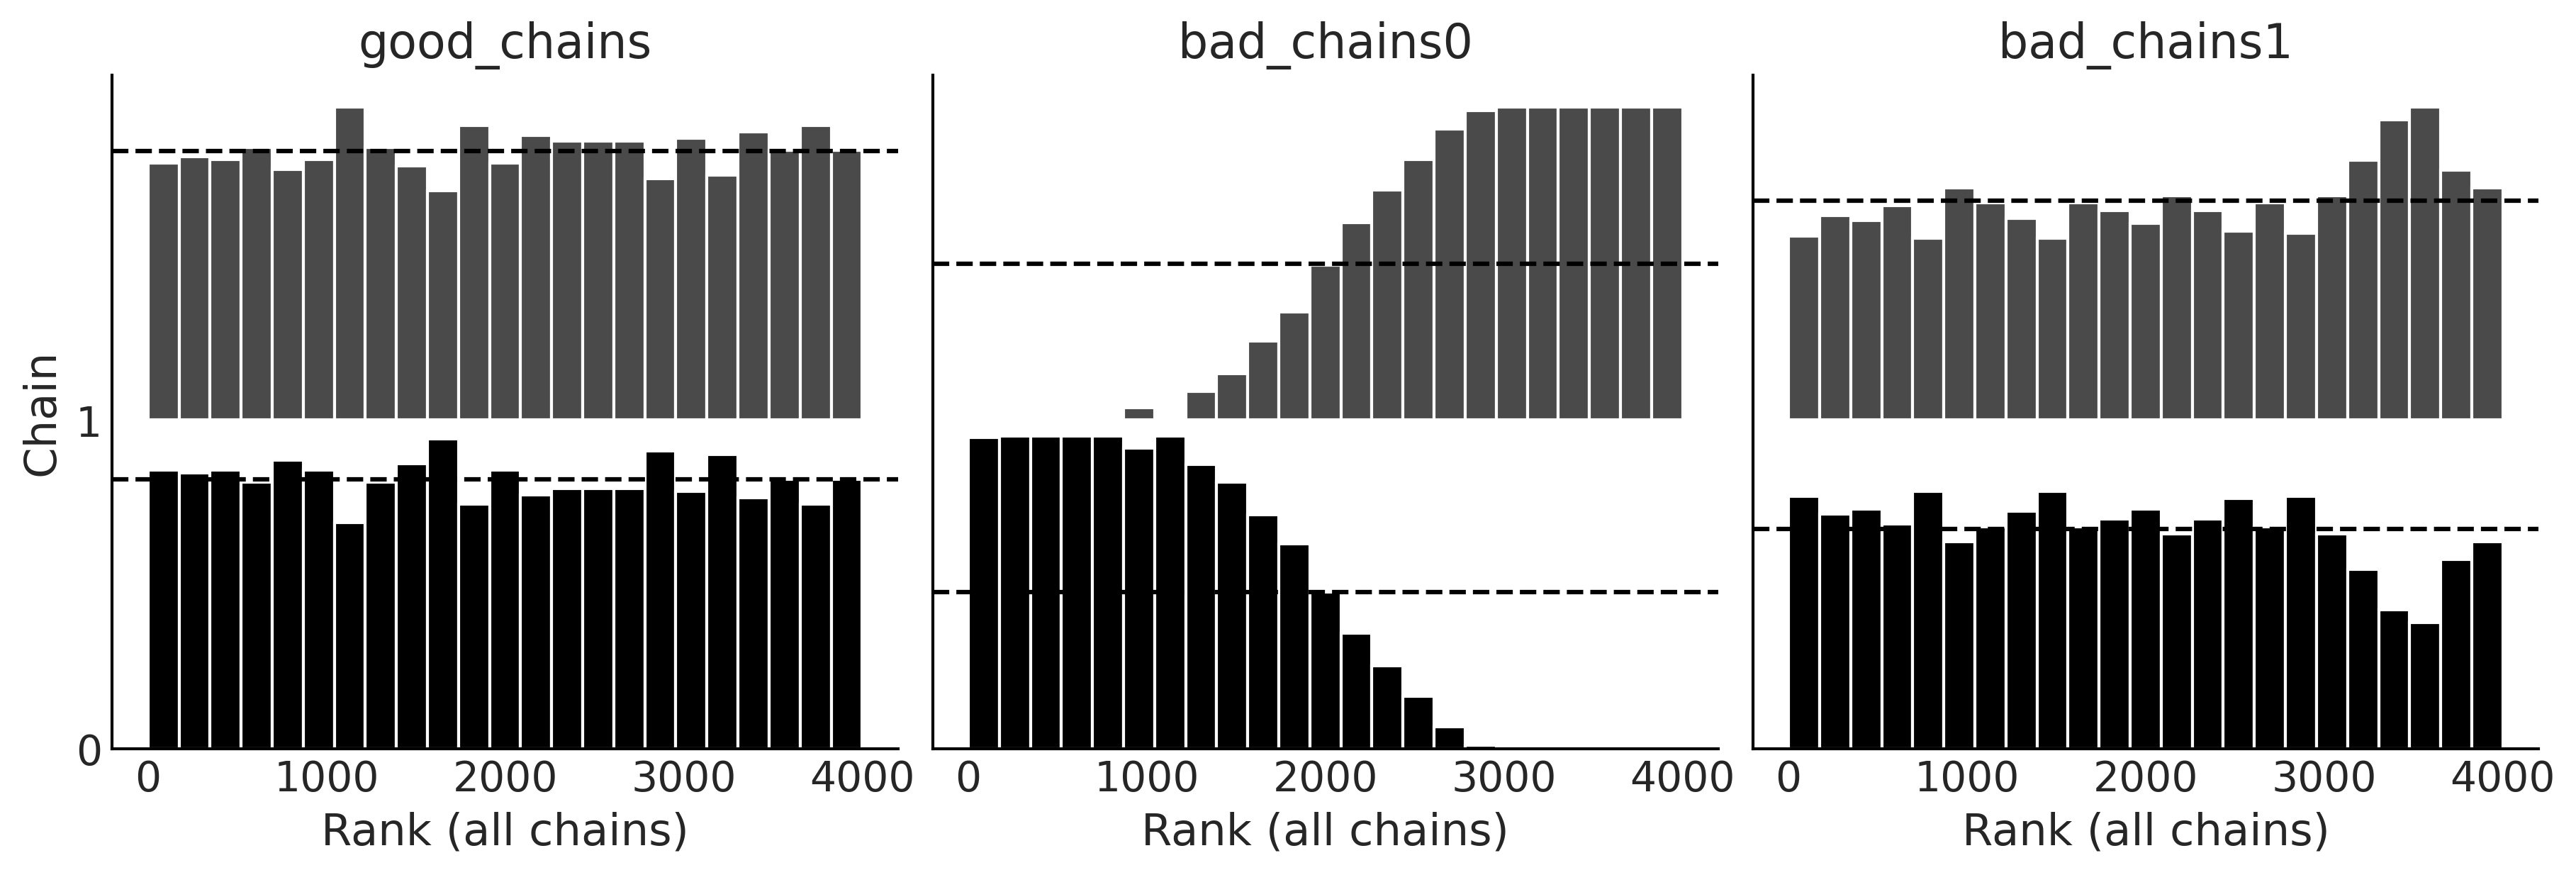

In [22]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))
az.plot_rank(chains, kind="bars", ax=axes)
for ax_ in axes[1:]:
    ax_.set_ylabel("")
    ax_.set_yticks([])

plt.savefig('img/chp02/rank_plot_bars.png')

### Code 2.11 and Figure 2.13

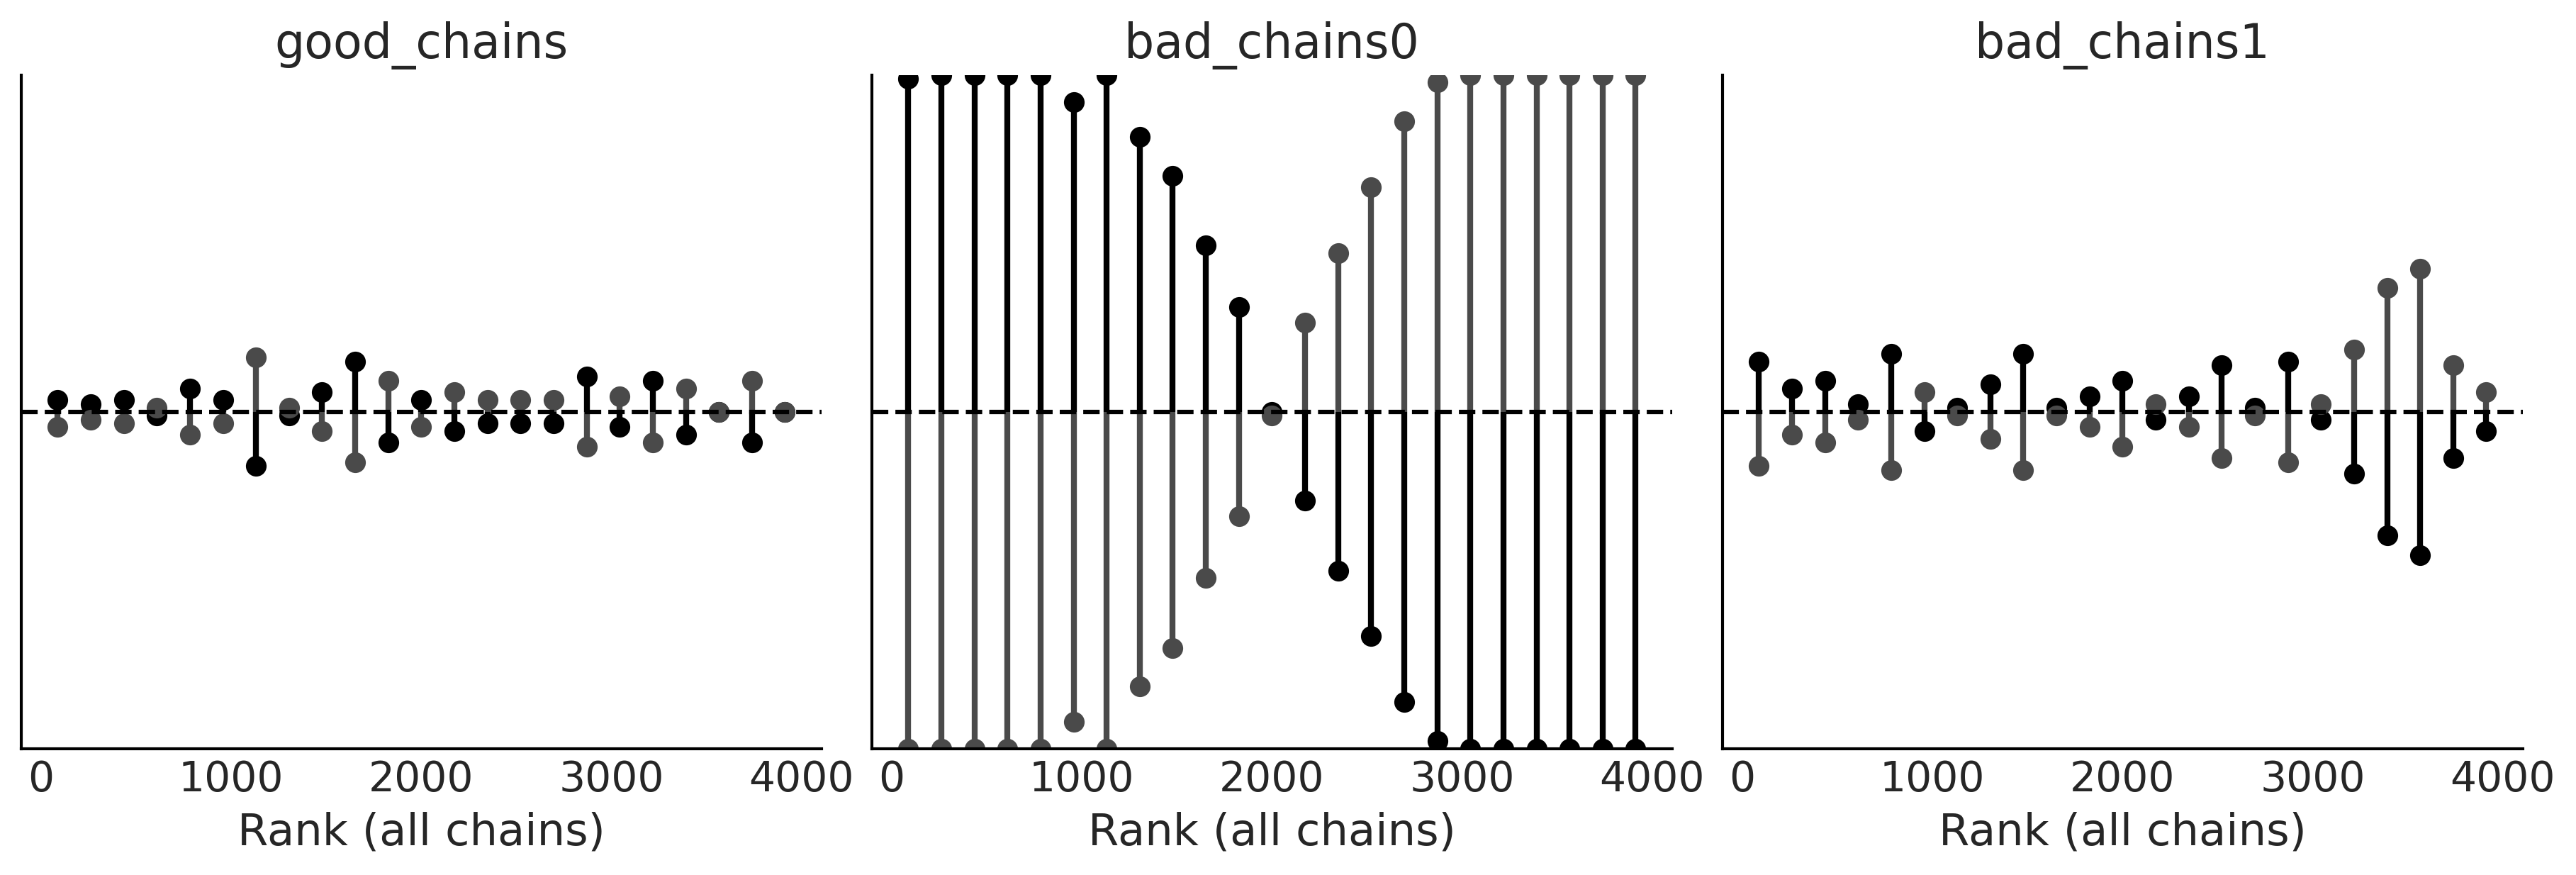

In [23]:
az.plot_rank(chains, kind="vlines", figsize=(12, 4))
plt.savefig('img/chp02/rank_plot_vlines.png')

### Code 2.12, 2.13, and 2.14

In [24]:
with pm.Model() as model_0:
    θ1 = pm.Normal("θ1", 0, 1, testval=0.1)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_0 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1:
    θ1 = pm.HalfNormal("θ1", 1 / (2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1bis:
    θ1 = pm.HalfNormal("θ1", 1 / (2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1bis = pm.sample(return_inferencedata=True, target_accept=0.95)

idatas = [idata_0, idata_1, idata_1bis]

/tmp/ipykernel_20659/207926017.py:2: FutureWarning: The `testval` argument is deprecated; use `initval`.
  θ1 = pm.Normal("θ1", 0, 1, testval=0.1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:752: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:752: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:752: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:752: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwarg

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 2270 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ1, θ2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ1, θ2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Figure 2.14

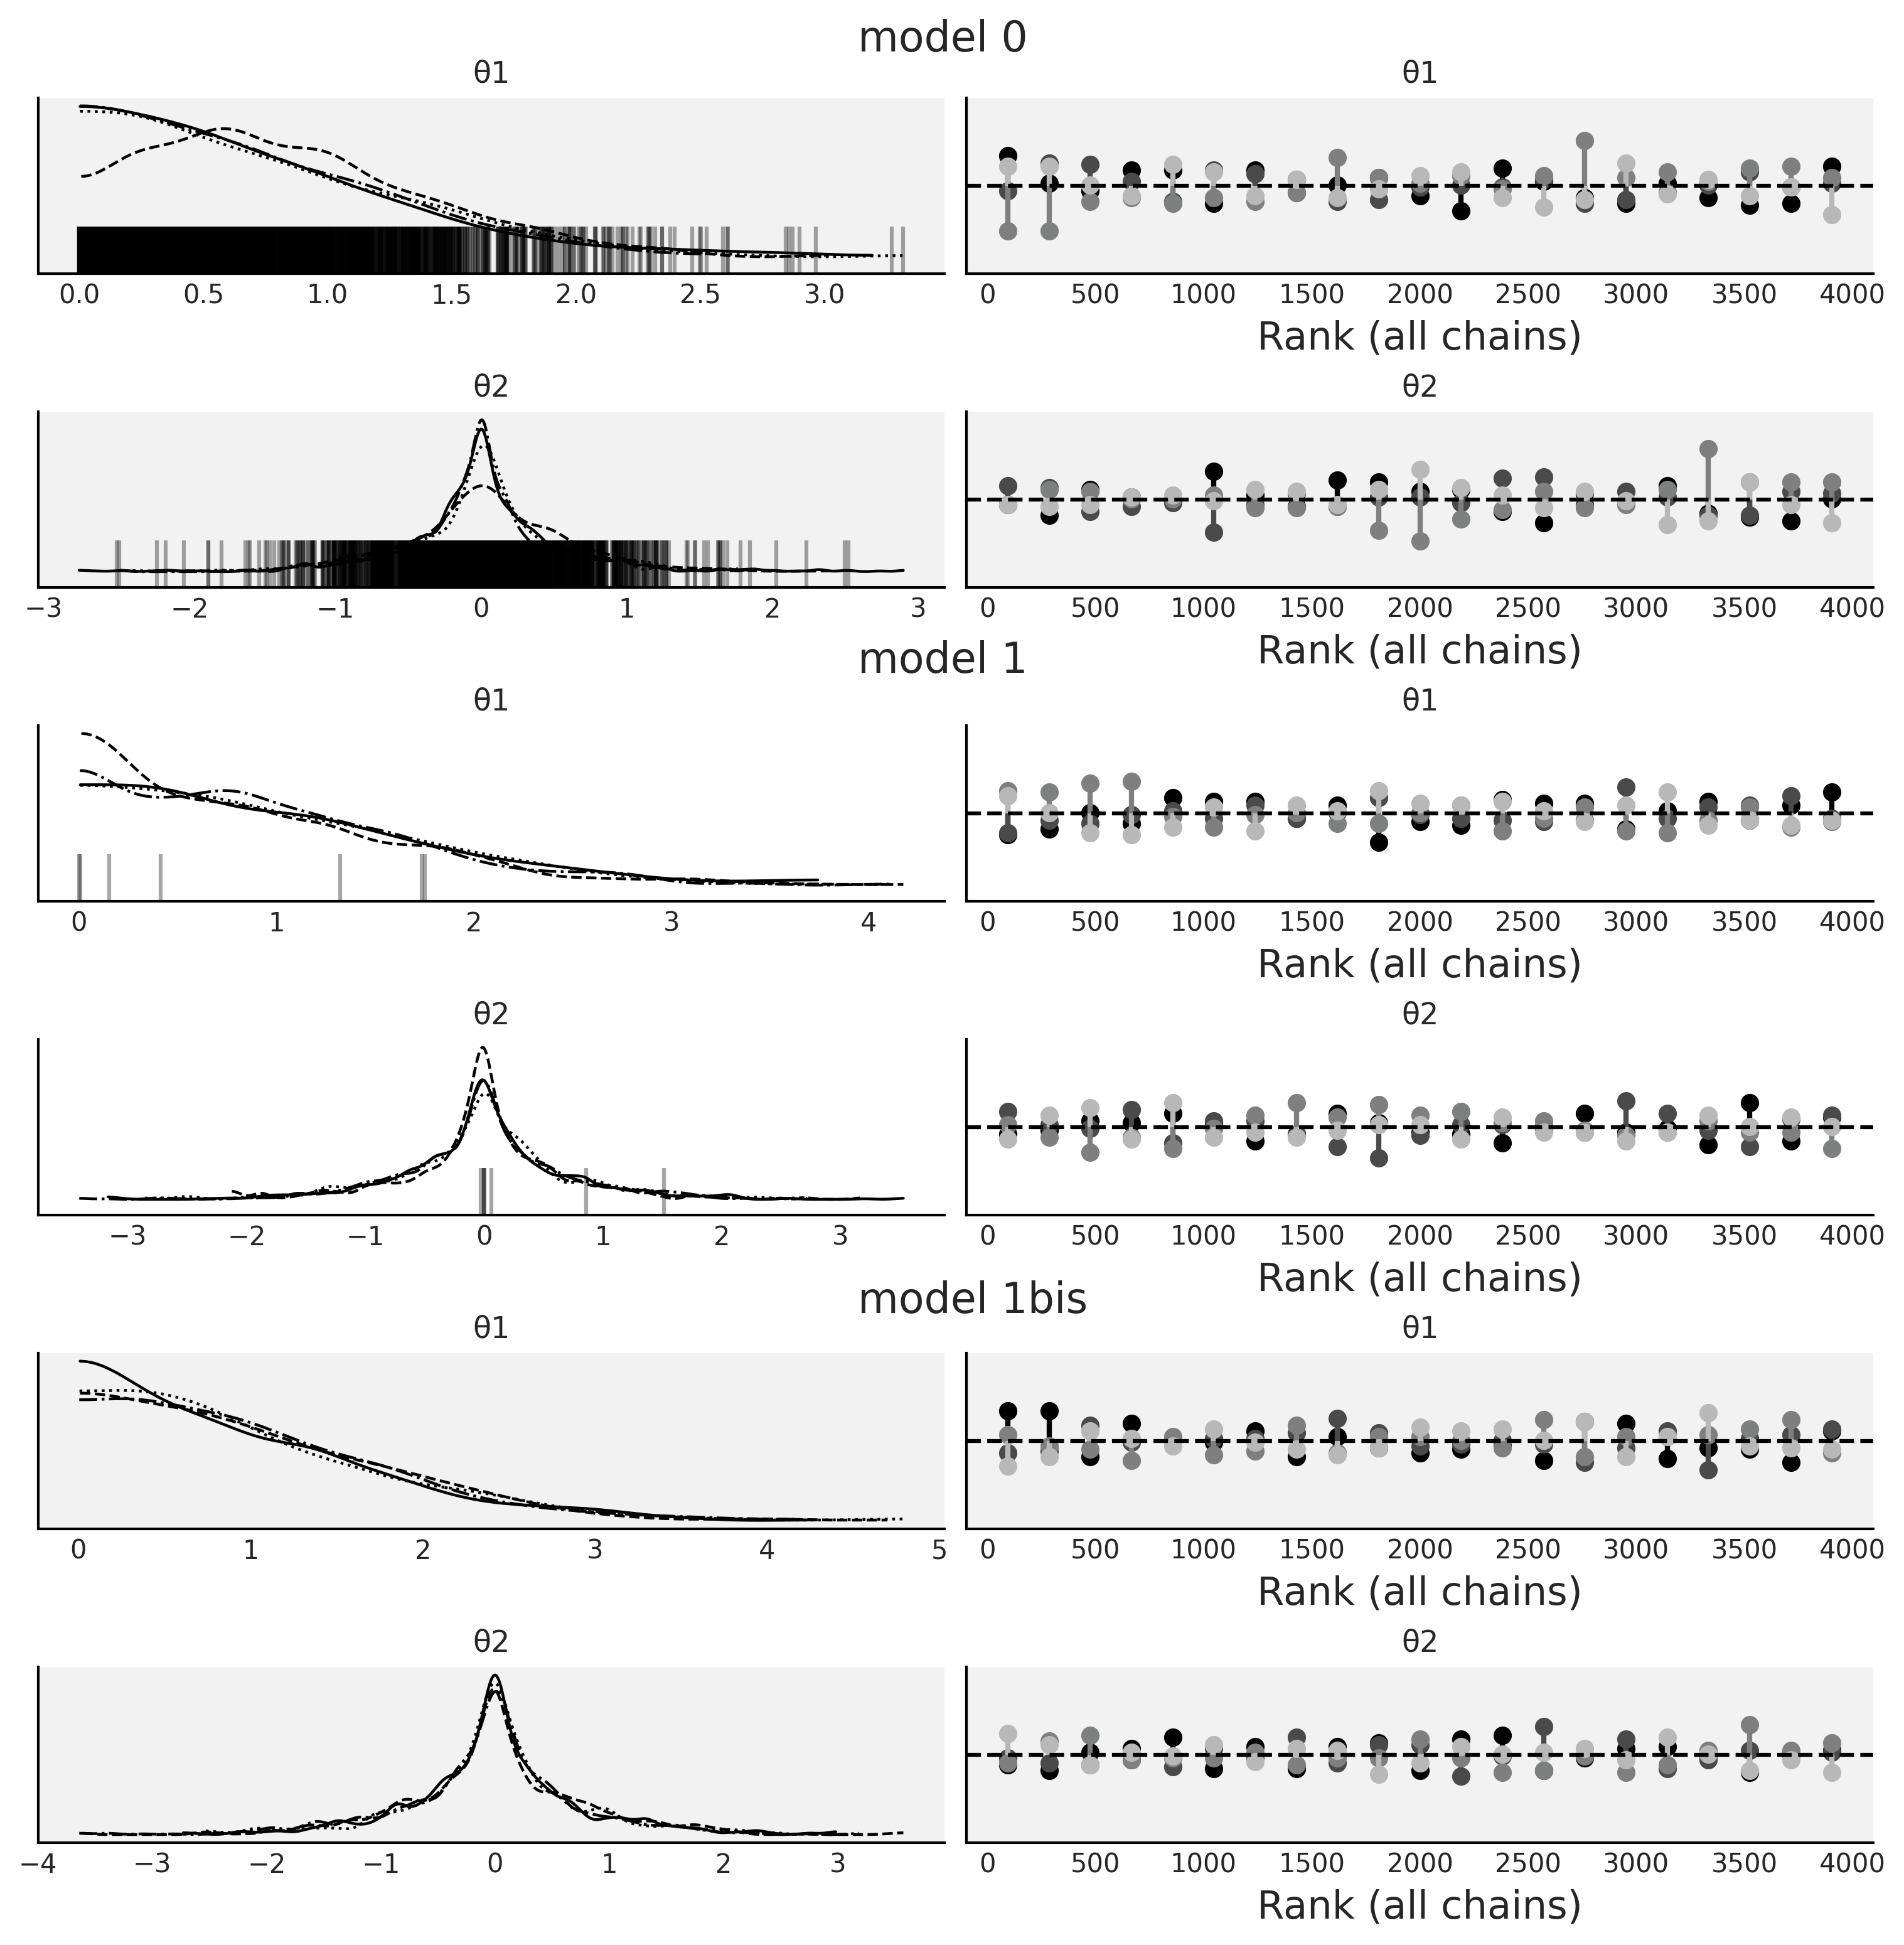

In [25]:
fig, axes = plt.subplots(6, 2, figsize=(10, 10))

axes = axes.reshape(3, 2, 2)
for idata, ax, color in zip(idatas, axes, ["0.95", "1", "0.95"]):
    az.plot_trace(idata, kind="rank_vlines", axes=ax);
    [ax_.set_facecolor(color) for ax_ in ax.ravel()]
fig.text(0.45, 1, s="model 0", fontsize=16)
fig.text(0.45, 0.67, s="model 1", fontsize=16)
fig.text(0.45, 0.33, s="model 1bis", fontsize=16)
plt.savefig("img/chp02/divergences_trace.png", bbox_inches="tight")

### Figure 2.15

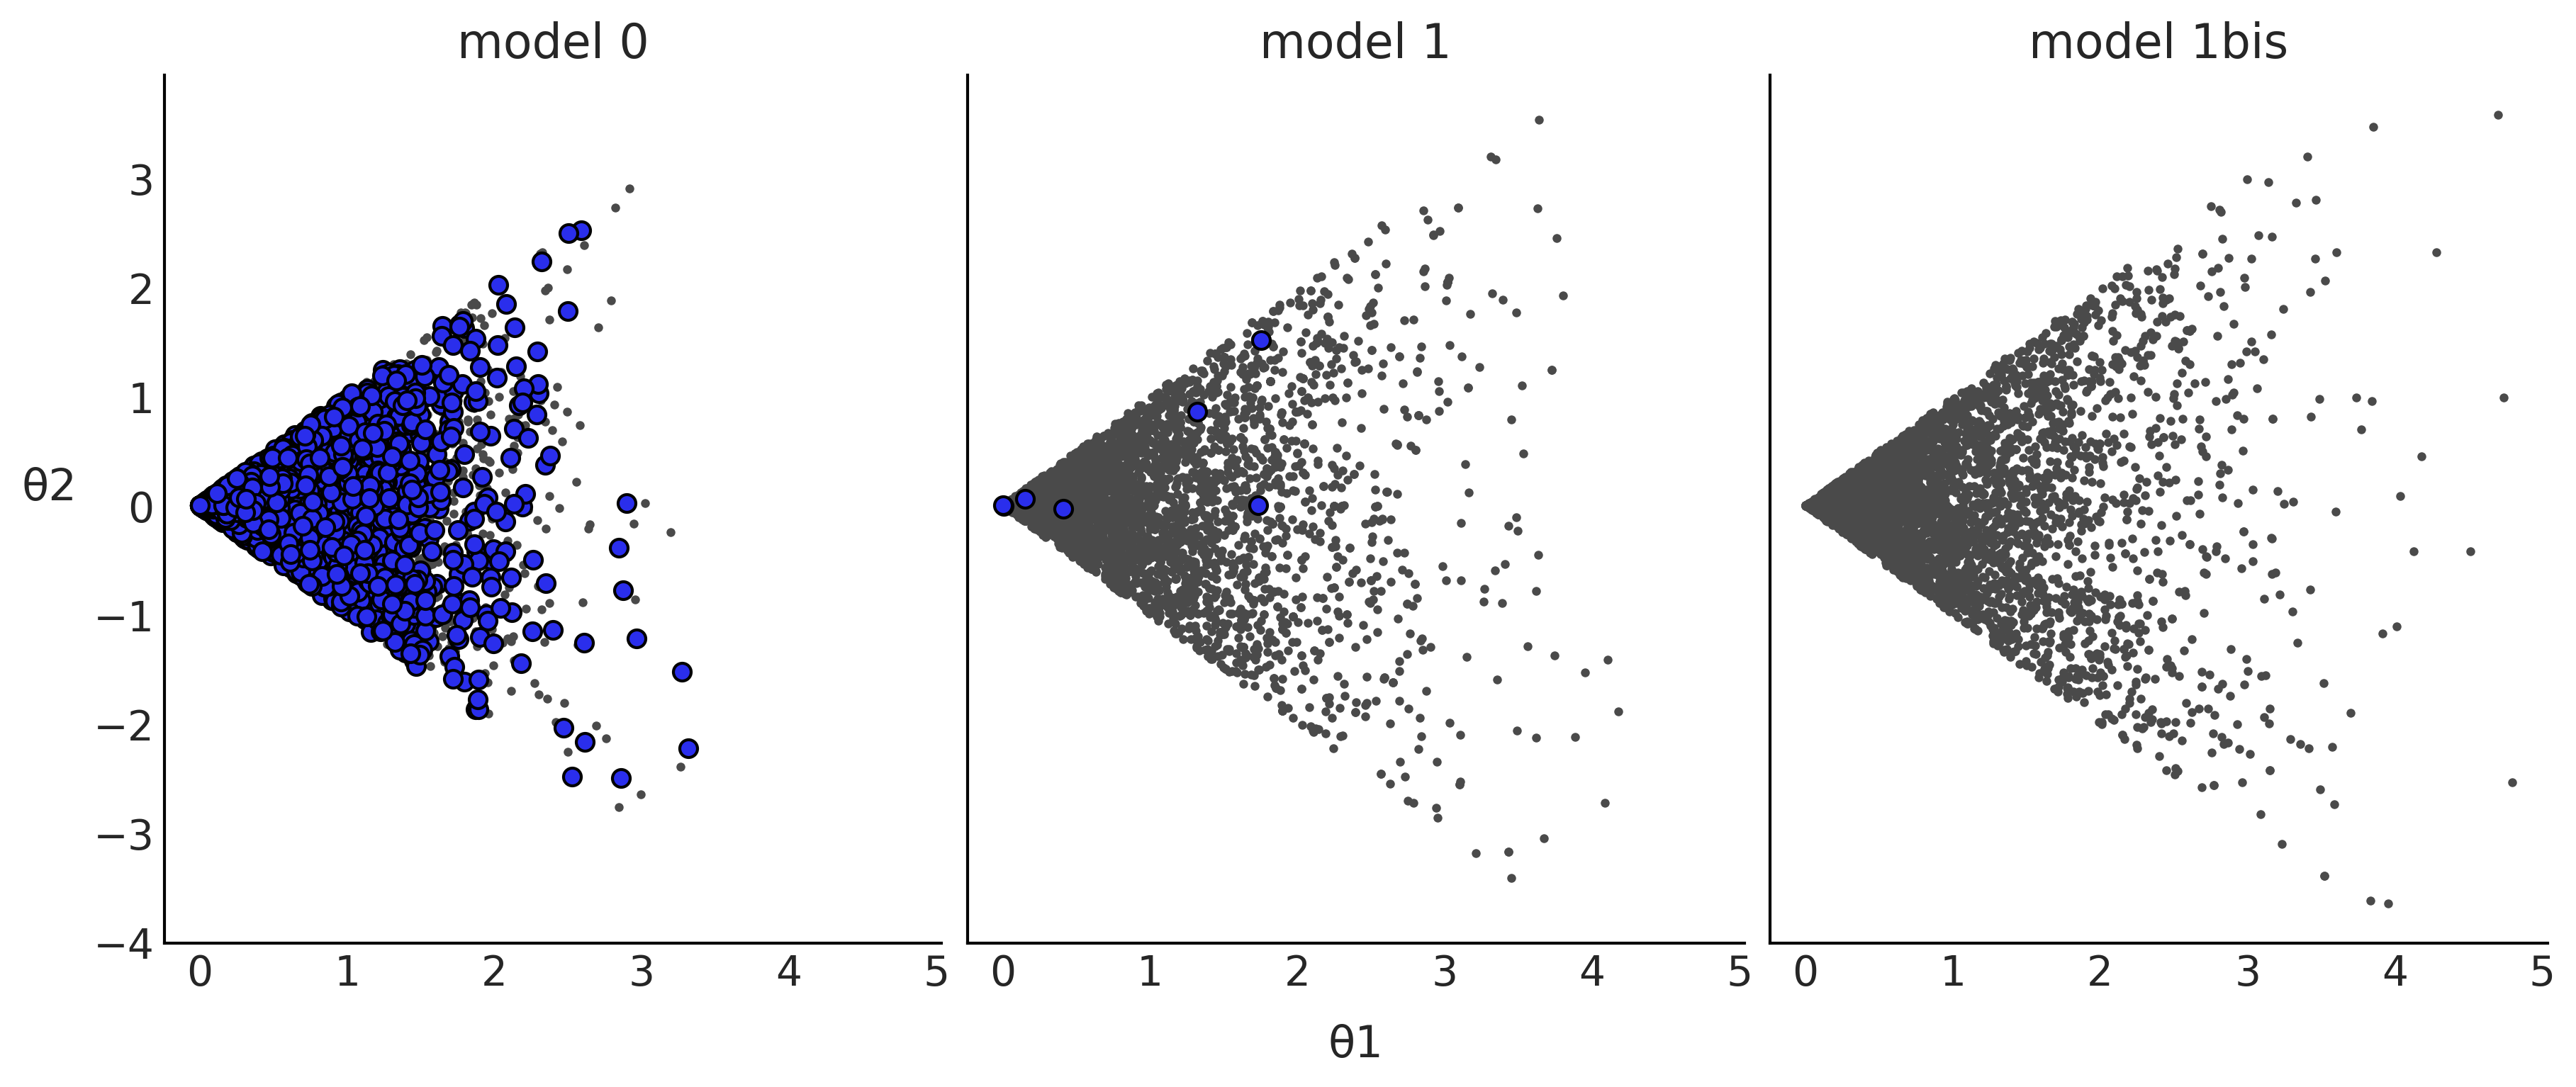

In [26]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

for idata, ax, model in zip(idatas, axes, ["model 0", "model 1", "model 1bis"]):
    az.plot_pair(idata, divergences=True, scatter_kwargs={"color":"C1"}, divergences_kwargs={"color":"C4"}, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(model)
axes[0].set_ylabel('θ2', rotation=0, labelpad=15)
axes[1].set_xlabel('θ1', labelpad=10)
plt.savefig("img/chp02/divergences_pair.png")

## Model Comparison

### Code 2.15

In [27]:
np.random.seed(90210)

In [28]:
y_obs =  np.random.normal(0, 1, size=100)
idatas_cmp = {}

with pm.Model() as mA:
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", mu=0, sigma=σ, alpha=1, observed=y_obs)
    idataA = pm.sample(idata_kwargs={"log_likelihood":True})
    idataA.extend(pm.sample_posterior_predictive(idataA))
    idatas_cmp["mA"] = idataA

with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    idataB = pm.sample(idata_kwargs={"log_likelihood":True})
    idataB.extend(pm.sample_posterior_predictive(idataB))
    idatas_cmp["mB"] = idataB

with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    idataC = pm.sample(idata_kwargs={"log_likelihood":True})
    idataC.extend(pm.sample_posterior_predictive(idataC))
    idatas_cmp["mC"] = idataC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


### Table 2.1

In [29]:
cmp = az.compare(idatas_cmp)
cmp.round(2)

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


rank  elpd_loo  p_loo  elpd_diff  weight     se   dse  warning scale
mB     0   -137.86   0.95       0.00     1.0   7.05  0.00    False   log
mC     1   -138.40   1.84       0.54     0.0   7.02  0.86    False   log
mA     2   -168.11   1.41      30.25     0.0  10.40  6.59    False   log

### Figure 2.16

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


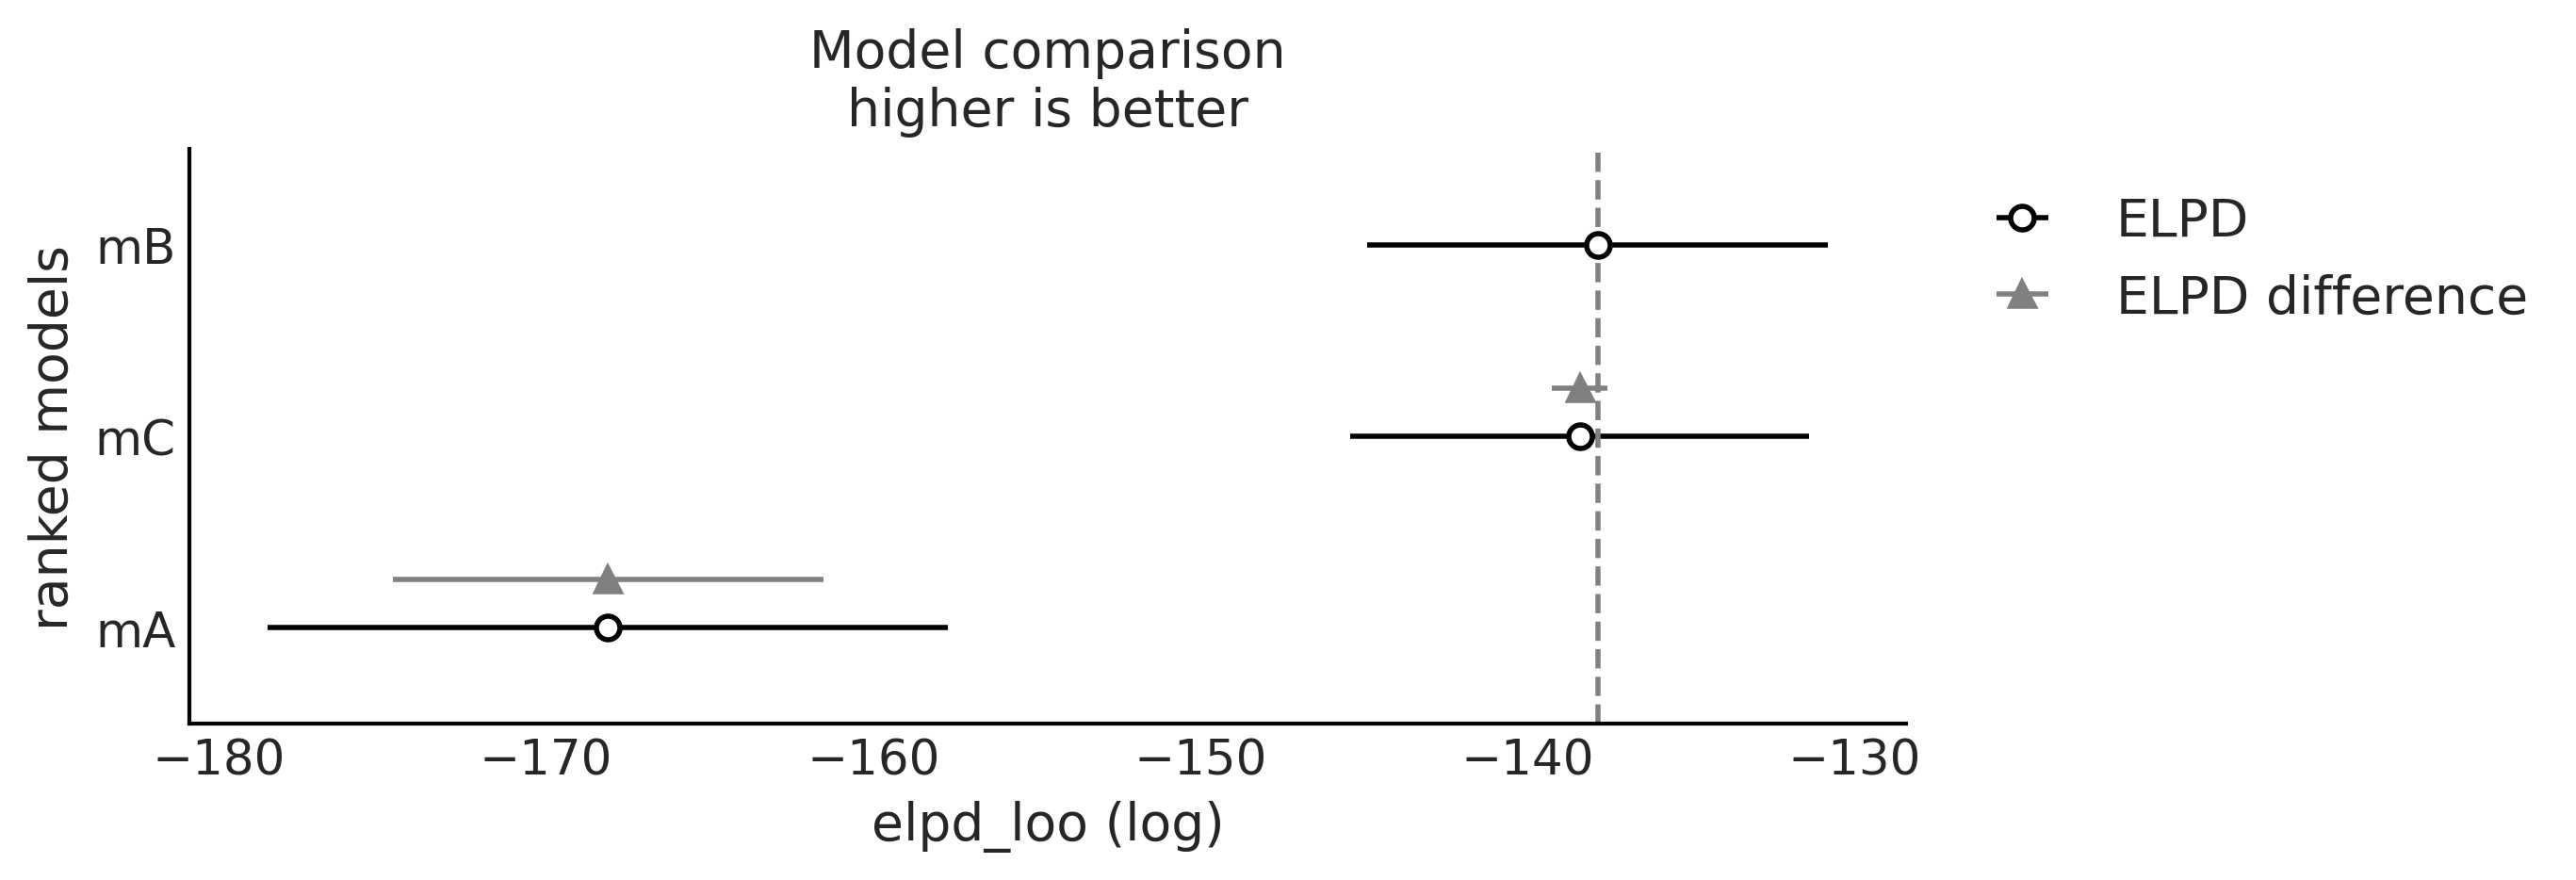

In [30]:
az.plot_compare(cmp, figsize=(9, 3))
plt.savefig("img/chp02/compare_dummy.png")

### Figure 2.17

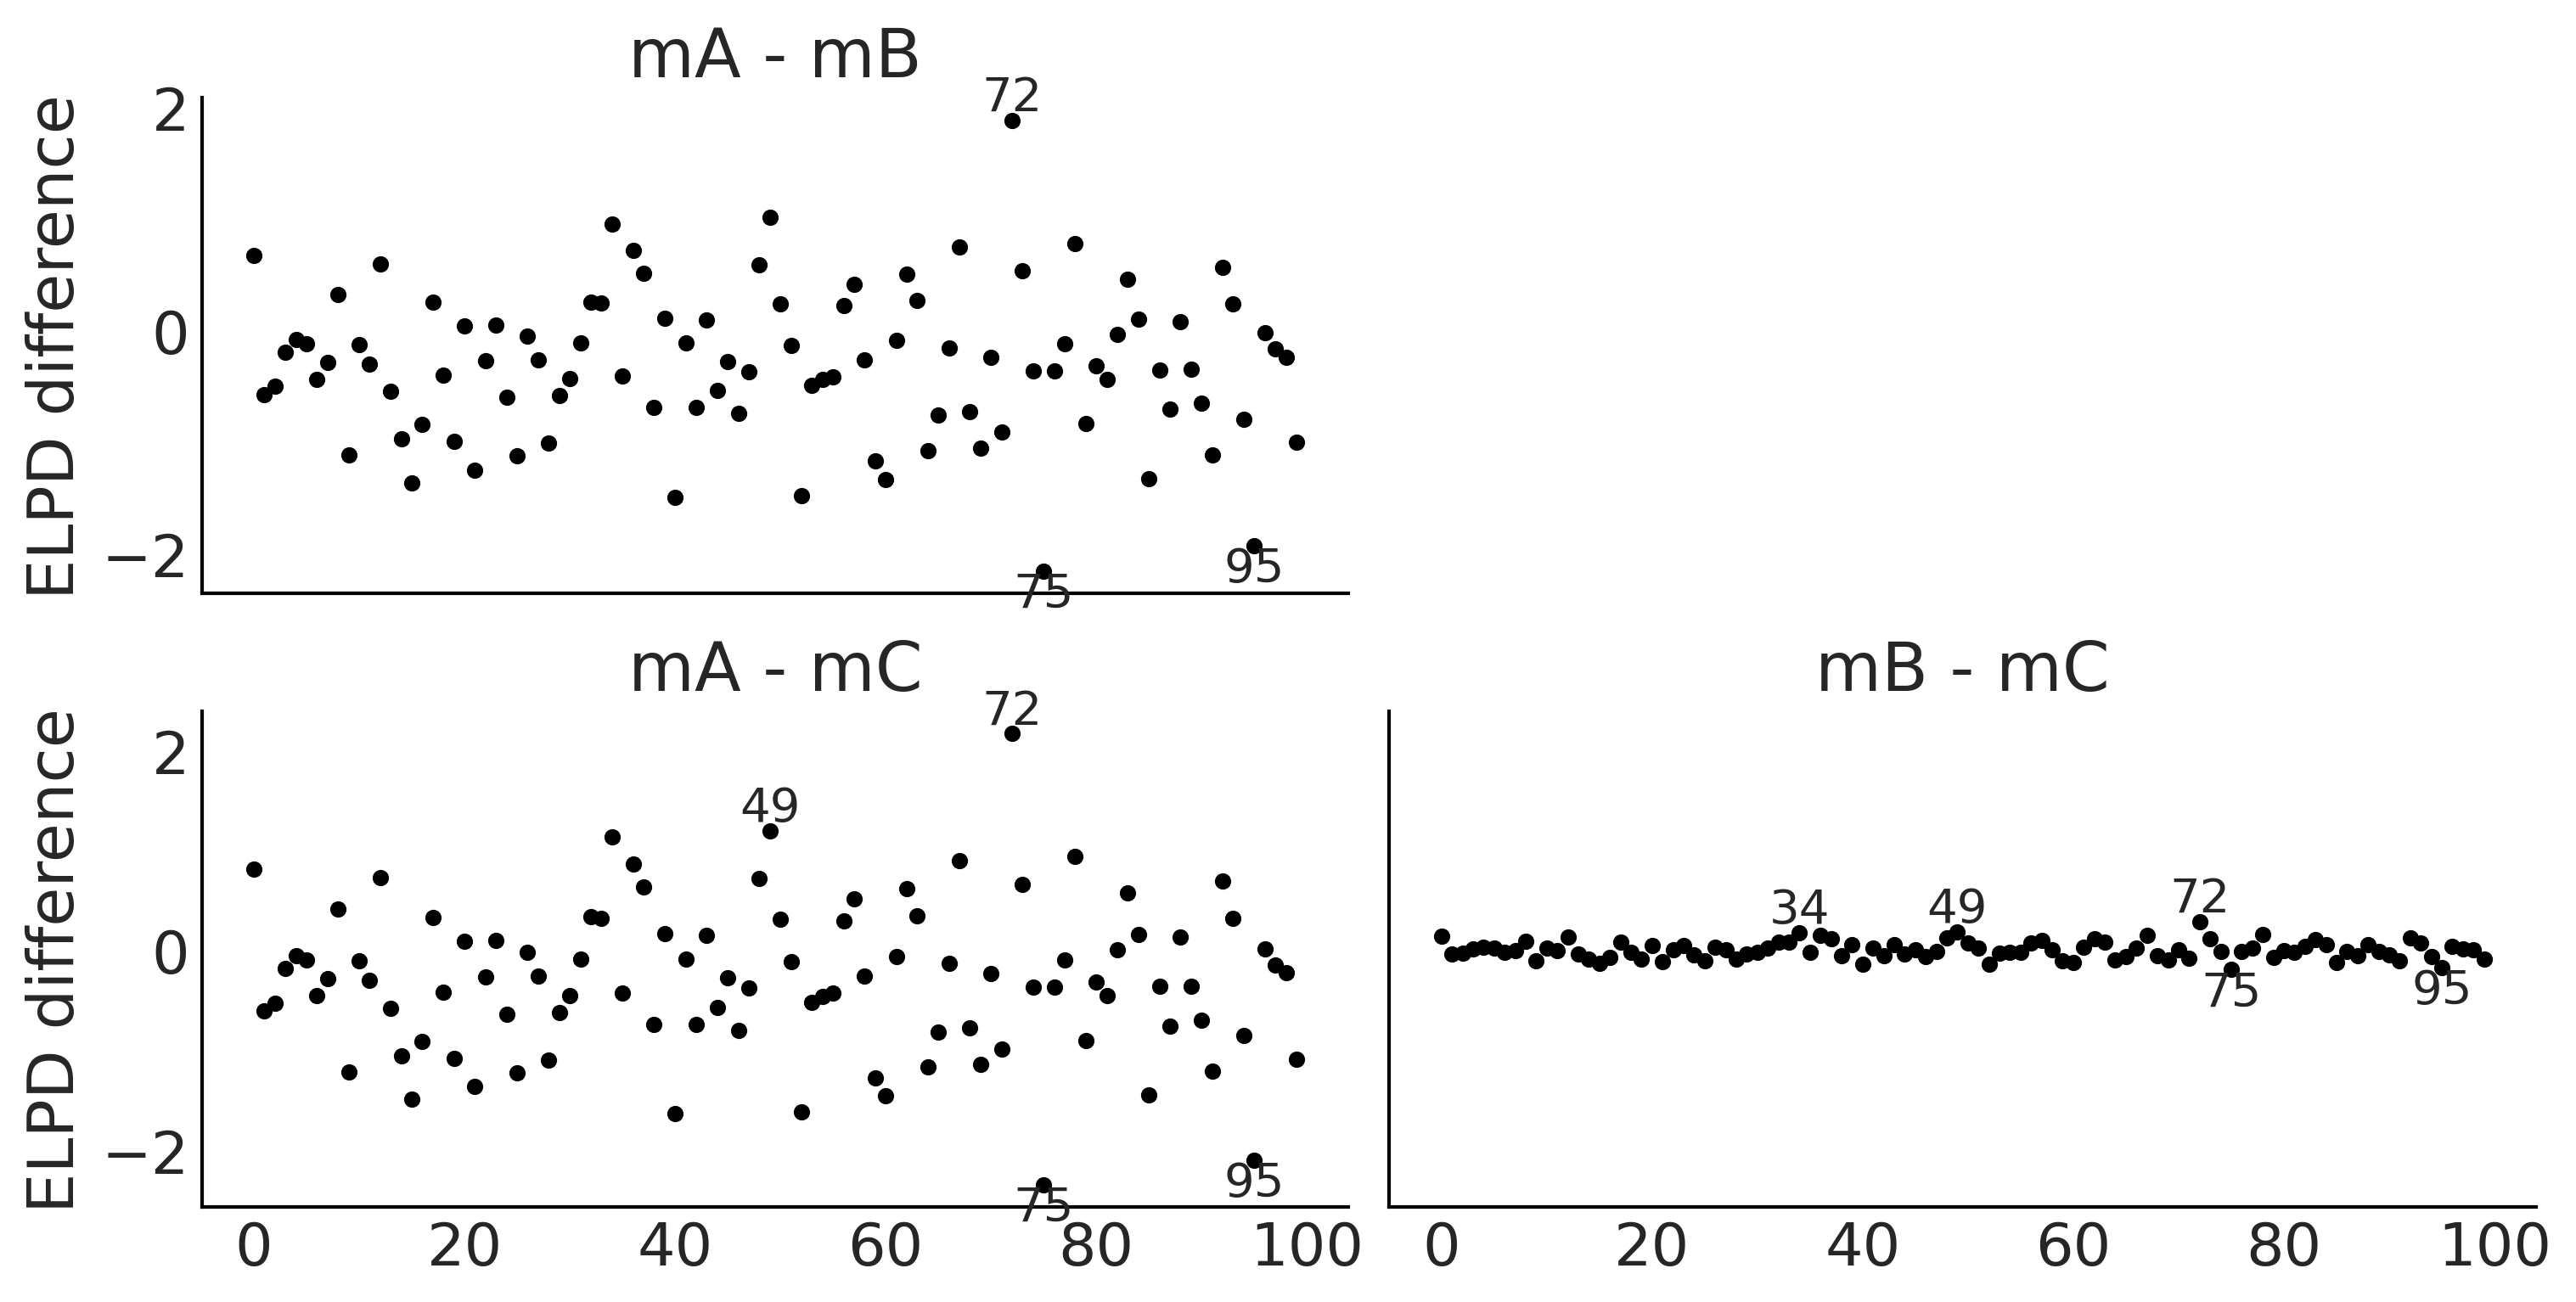

In [31]:
az.plot_elpd(idatas_cmp, figsize=(10, 5), plot_kwargs={"marker":"."}, threshold=2);
plt.savefig("img/chp02/elpd_dummy.png")

### Figure 2.18

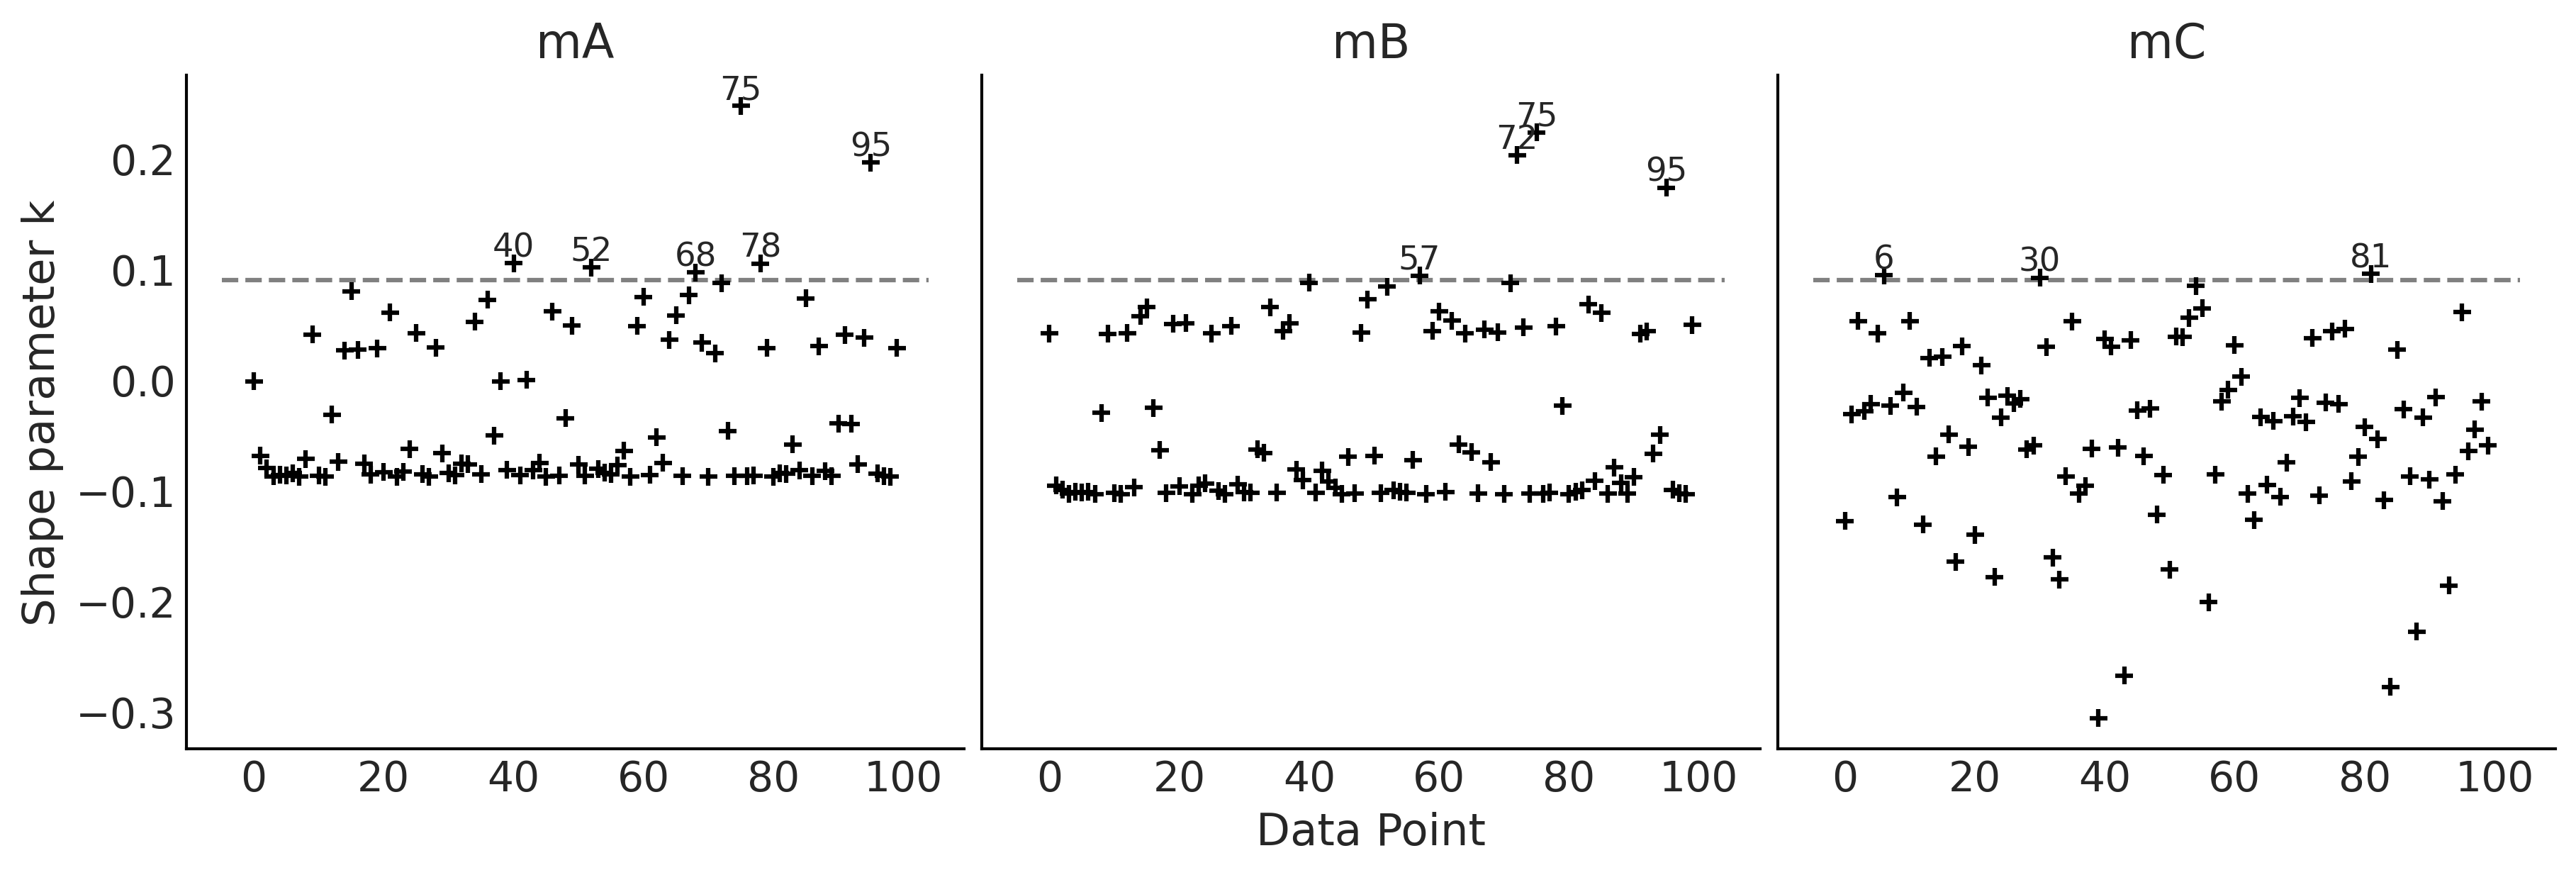

In [32]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for idx, (model, ax) in enumerate(zip(("mA", "mB", "mC"), axes)):
    loo_ = az.loo(idatas_cmp[model], pointwise=True)
    az.plot_khat(loo_, ax=ax, threshold=0.09, show_hlines=True, hlines_kwargs={"hlines":0.09, "ls":"--"})
    ax.set_title(model)
    if idx:
        axes[idx].set_ylabel("")
    if not idx % 2:
        axes[idx].set_xlabel("")

plt.savefig("img/chp02/loo_k_dummy.png")

### Figure 2.19

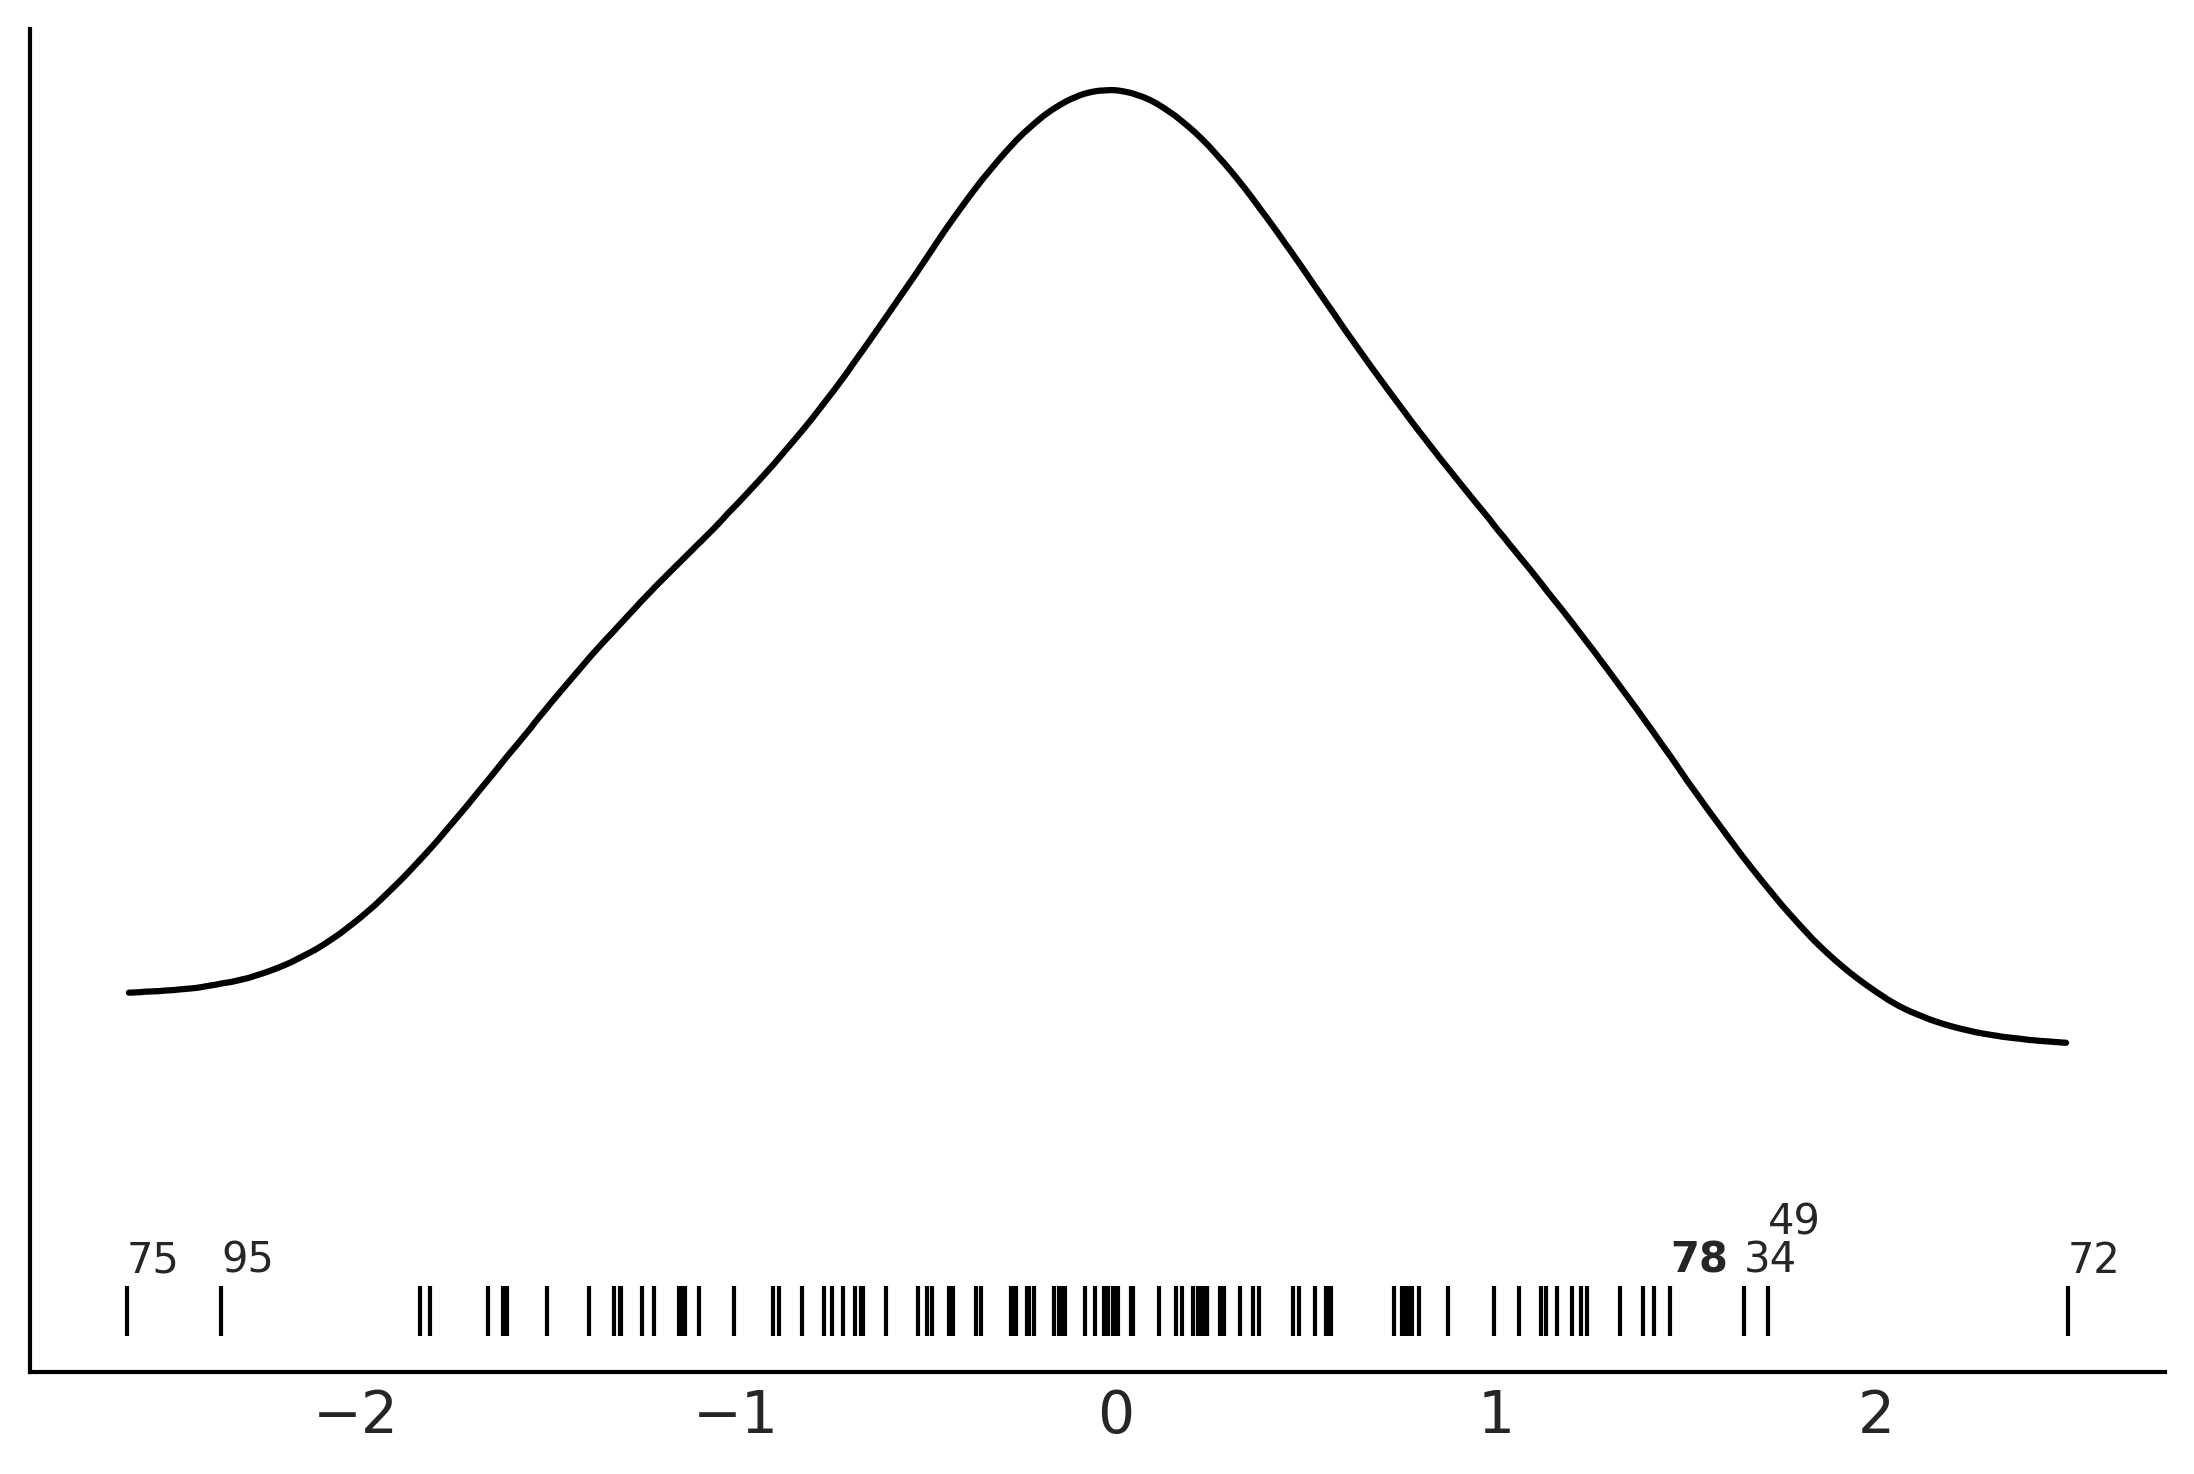

In [33]:
az.plot_kde(y_obs, rug=True)
plt.yticks([])
for da, loc in zip([34, 49, 72, 75, 95], [-0.065, -0.05, -0.065, -0.065, -0.065]):
    plt.text(y_obs[da], loc, f"{da}")

plt.text(y_obs[78], loc, "78", fontweight='bold');
plt.savefig("img/chp02/elpd_and_khat.png")

### Figure 2.20

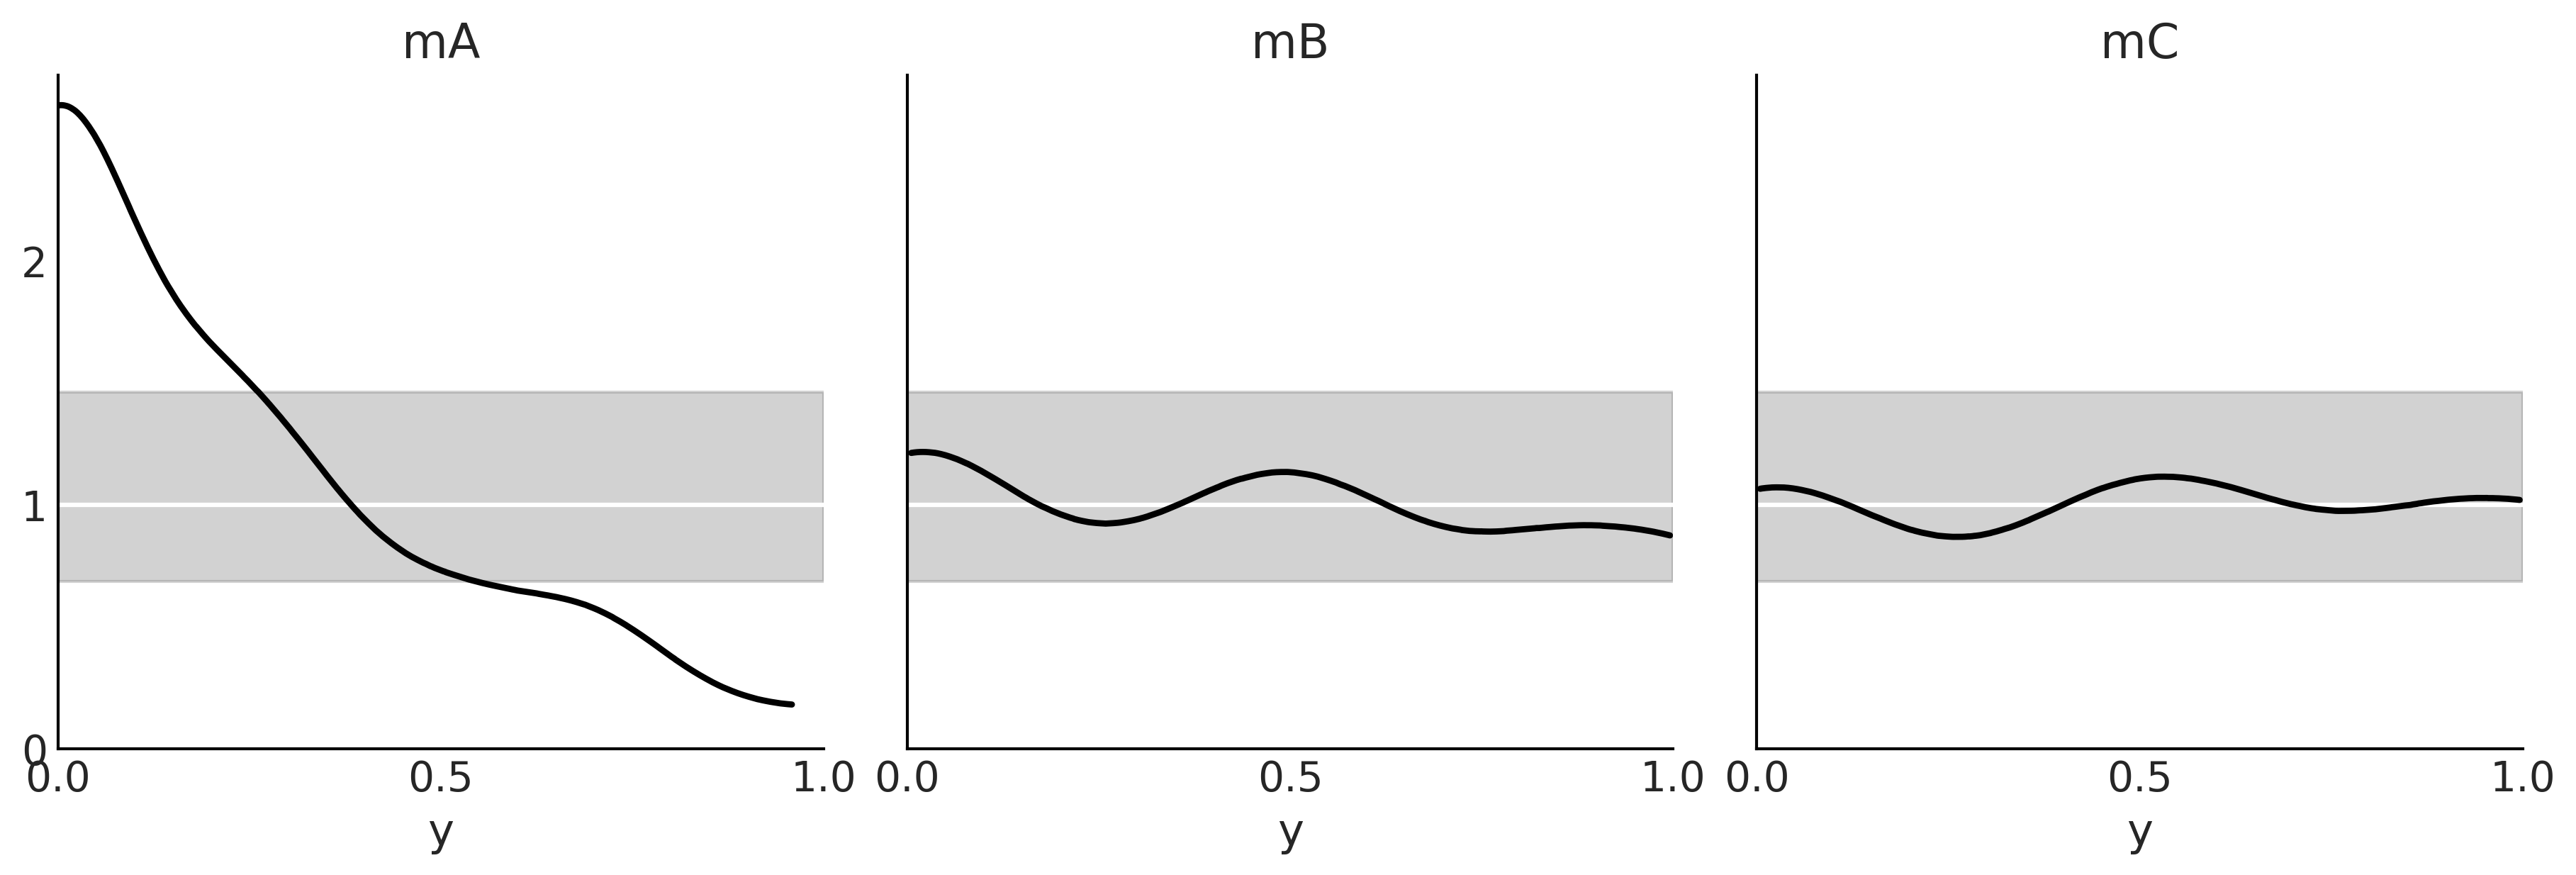

In [34]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for model, ax in zip(("mA", "mB", "mC"), axes):
    az.plot_loo_pit(idatas_cmp[model], y="y", legend=False, use_hdi=True, ax=ax)
    ax.set_title(model)
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])

plt.savefig("img/chp02/loo_pit_dummy.png")